# Data Munging Project Presentation
## Group: Alexandra Landry, Julius Xanthoudakis, Neil Aucoin, Tereza Rosier

### Concept: clustering headlines and determine what types of news are most common
#### API used: NewsAPI  (https://newsapi.org/) - Returns JSON search results for current and historic news articles from over 80,000 worldwide sources

In [1]:
# Imports
from newsapi import NewsApiClient
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction import text
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from string import punctuation
import gensim
import gensim.downloader as model_api
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt


# # Download NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')

In [ ]:
pip install newsapi-python

### We started by using NewsAPI to extract the top 100 headlines from the last week and clustered them using Bag of Words and KMeans

In [5]:
# Define API key
api_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

# Initialize NewsApiClient
newsapi = NewsApiClient(api_key=api_key)

# Create a empty list to store DataFrames
dfs = []

# Calculate the date range for the past week
end_date = datetime.now()
start_date = end_date - timedelta(days=7)

# Iterate through each day in the date range
current_date = start_date
while current_date <= end_date:
    # Convert date to required format
    formatted_date = current_date.strftime('%Y-%m-%d')
    
    # Fetch news articles for current date and sort by relevancy
    articles = newsapi.get_everything(q='news', language='en', from_param=formatted_date, to=formatted_date, sort_by='relevancy', page_size=100)
    
    # Create DataFrame for the articles
    article_list = [{'date': formatted_date, 'headline': article['title'], 'source': article['source']['name']} for article in articles['articles']]
    df = pd.DataFrame(article_list)
    
    # Append the DataFrame to the list
    dfs.append(df)
    
    # Move to next day
    current_date += timedelta(days=1)

# Concatenate all DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

# Vectorize headlines using Bag of words
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(result_df['headline'])

# Perform KMeans clustering
num_clusters = 25  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Add cluster labels to the DataFrame
result_df['cluster'] = kmeans.labels_

# Print clustered headlines for each cluster
for cluster_id in range(num_clusters):
    print(f"Cluster {cluster_id + 1}:")
    cluster_headlines = result_df[result_df['cluster'] == cluster_id]['headline']
    for headline in cluster_headlines:
        print("-", headline)
    print()

print(result_df.shape)

C:\Users\Niocu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 1:
- Warnock steps down as Aberdeen interim boss with new appointment close
- A new type of pilot could be key to solving a looming crisis in the skies
- The new moon lets the winter constellations shine tonight
- How imposters are trying to exploit your grief and wallet in a new funeral scam
- Gaza war fuels Jerusalem fears as Ramadan to begin
- 'Harry Potter' Star Miriam Margolyes Says Adult Fans Need to Grow Up
- Muslim countries announce start of Ramadan in shadow of Gaza war
- Is­rael’s war on Gaza: List of key events, day 156
- NEWS YOU CAN USE: Lifesaving Skills Every Gun Owner Should Know.
- Aero-News: Quote of the Day (03.11.24)
- Why Shiba Budz (BUDZ) Cryptocurrency Is The New SHIB Wave In 2024
- Sen. Bob Menendez pleads not guilty to obstruction charges in new federal indictment
- Jake Lloyd's Mother Pushes Back Against Idea That He Hates Star Wars
- The Download: rise of the multimodal robots, and the SEC’s new climate rules
- Some EV Recalls Are Serious, Others Not

## The resulting clusters were unclear, so we tried printing just the 5 most representative headlines for each cluster

In [8]:
# Find top 5 most representative headlines from each cluster

# Find the centroids of each cluster
centroids = kmeans.cluster_centers_

# Find the closest titles to each centroid
closest_titles = []
for centroid in centroids:
    distances = np.linalg.norm(X - centroid, axis=1)
    closest_idx = np.argsort(distances)[:5]  # Choose top 5 closest titles
    closest_titles.append(result_df.iloc[closest_idx]['headline'].tolist())

# Print the representative titles for each cluster
for cluster_id, titles in enumerate(closest_titles):
    print(f"Cluster {cluster_id + 1}:")
    for title in titles:
        print("-", title)
    print()
    
print(result_df.shape)

Cluster 1:
- You'll Love These New Star Wars Eyes, We Know
- Patty Jenkins’ Star Wars movie is apparently back on
- Patty Jenkins Claims She's Back on Star Wars: Rogue Squadron
- Japanese baseball star unveils new wife's identity
- Jake Lloyd's Mother Pushes Back Against Idea That He Hates Star Wars

Cluster 2:
- Samsung’s best Galaxy A-series device might not be coming to the US
- Bad news: Samsung’s successor to the best cheap phone of 2023 isn’t coming to the US
- Samsung's Galaxy S24 is outselling last year's S23 series by 14% in the US
- These are the best and coolest Apple Watch faces
- These are the best and coolest Apple Watch faces

Cluster 3:
- 2024 Oscars live stream: how to watch the Oscars for free
- Mumbai News Live Updates: Maharashtra CM Eknath Shinde inaugurates 1st phase of coastal road
- Jets vs Canucks live stream: Can you watch for free?
- Special counsel hearing live updates: Hur to testify about Biden documents probe
- We’re Already Living in the Post-Truth Era



## These results were more promising, so we decided to proceed with this concept and data source

# We then broke the data down into multiple steps to avoid API limits and try different clustering methods
## We also decided to use one month of data (due to API limitations) - resulting in headlines from to Feb 12, 2024 to March 13, 2024
### We split this range into 4 periods so we could each extract one week and then concatenate them all

In [3]:
# Everyone gets articles for a week, then saves as json files (source: BBC)
# Neil 2024-3-6 to 2024-3-12

# Tereza
#FROM 2024-02-27 to 2024-03-05

# Julius
#FROM 22024-02-19 to 2024-02-26

# Alexandra
#FROM 2024-2-12 to 2024-2-18

#date was changing manually
date = '2024-03-05'

def get_articles(end_date, start_date, api_key):
    newsapi = NewsApiClient(api_key=api_key)
    
    # Fetch news articles for the current date (sorted by relevancy)
    articles = newsapi.get_everything(sources='bbc-news', language='en', from_param=start_date, to=end_date, sort_by='relevancy', page_size=100)
    
   
    return articles
 
    
articles = get_articles(date, date, 'xxxxxxxxxxxxxxxxxxxxxxxxxxxx')

import json
with open(f'articles_{date}.json', 'w') as f:
    json.dump(articles, f)

## We limited our article searches to BBC News 
### We also removed the q='news' parameter as it resulted in better clustering results

### We then concatenated the json files into one dataframe (repeated for each date range)

In [ ]:
# List to store the DataFrames of each JSON file
dfs = []

# Names of the JSON files
file_names = ['articles_2024-02-12.json','articles_2024-02-13.json','articles_2024-02-14.json','articles_2024-02-15.json','articles_2024-02-16.json','articles_2024-02-17.json','articles_2024-02-18.json','articles_2024-02-19.json','articles_2024-02-20.json','articles_2024-02-21.json','articles_2024-02-22.json', 'articles_2024-02-23.json', 'articles_2024-02-24.json', 'articles_2024-02-25.json', 'articles_2024-02-26.json', 'articles_2024-02-27.json', 'articles_2024-02-28.json', 'articles_2024-02-29.json','articles_2024-03-01.json','articles_2024-03-02.json','articles_2024-03-03.json','articles_2024-03-04.json','articles_2024-03-05.json','articles_2024-03-06.json','articles_2024-03-07.json','articles_2024-03-08.json','articles_2024-03-09.json','articles_2024-03-10.json','articles_2024-03-11.json','articles_2024-03-12.json','articles_2024-03-13.json']


# Read each JSON file and store the resulting DataFrame in the 'dfs' list
for file_name in file_names:
    df = pd.read_json(file_name)
    dfs.append(df)

# Concatenate the DataFrames from the 'dfs' list into a single DataFrame
df_json_articles = pd.concat(dfs, ignore_index=True)

# With this done, we then cleaned the data through normalization and duplicate removal before turning it back into a dataframe

In [ ]:
df_articles = pd.json_normalize(df_json_articles['articles'])

In [ ]:
duplicates = df_articles.duplicated(subset=['title'])
duplicate_rows = df_articles[duplicates]
df_articles_dropped = df_articles.drop_duplicates(subset=['title'],keep='first')

In [ ]:
df_articles_dropped.to_csv('Articles_BBC.csv')

# We then experimented using this new concatenated dataframe using stop words, TF-IDF and pre-trained embeddings, with KMeans clustering

## Creation of functions for preprocessing

In [2]:
# Preprocessing - stemming
def custom_tokenizer(text):
    words = nltk.word_tokenize(text)
  
    # Apply stemming
    stemmer = PorterStemmer()
    base_form_stemmed_words = []
    for word in words:
        if "'" in word:
            # Skip words like I'm, since they will be broken into I and 'm
            continue
        word = stemmer.stem(word)  # Reduce words to their base or root form
        base_form_stemmed_words.append(word)
    
    # Join the stemmed words back into a preprocessed string
    return ' '.join(base_form_stemmed_words)

In [3]:
# Embedding using glove-wiki
word_vectors = model_api.load("glove-wiki-gigaword-50")

# Functions definition for running preprocessing

# Removing special character

replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" "
})
rep = dict((re.escape(k),v) for k, v in replaceDict.items())
def replacer(text):
    return rep[re.escape(text.group(0))]

def express_remove(df):
    pattern = re.compile('|'.join(rep.keys()))
    words = df.title.str.replace(pattern, replacer).str.lower()
    words = words.str.split()
    words = pd.DataFrame(words.tolist())
    return words


# Removing english stop words 
# from # https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
stop_words =['f','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 
'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 
'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 
'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 
's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y',
 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", "don't", 
'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn',
 "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 
'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

def stopwords_remove(words):
    for i in range(len(words)):
        for j in range(len(words.iloc[i])):
            element = words.iloc[i][j]
            if element in stop_words:
                words.iloc[i][j] = None
            else:
                 pass
    return words


# Removing choosen words base on context
news_words = ['news', 'audio', 'listen','watch', 'breaking', 'interview', 'seek', 'CBS', 'Weekend']

def choosenwords_remove(words):
    for i in range(len(words)):
        for j in range(len(words.iloc[i])):
            element = words.iloc[i][j]
            if element in news_words:
                words.iloc[i][j] = None
            else:
                pass
    return words


# Applying the embedding
def soft_get(w):
    try:
        return word_vectors[w] #either get the word or return 0s
    except KeyError:
        return np.zeros(word_vectors.vector_size)

def map_vectors(row):
    try:
        #print(row)
        exit = row.loc[words.iloc[row.name].notna()].apply(soft_get)
        return np.sum(exit)
    # take the row and take the columns that are not NaN and get the soft_get and then take the sum of that
    except:
        return np.zeros(word_vectors.vector_size)

## Creation of functions for clustering evaluation

In [4]:
def visualize_elbow(X, ks):
    fig, ax = plt.subplots()
    inertias = []
    for k in ks:
        inertias.append(KMeans(n_clusters=k, random_state=10).fit(X).inertia_)
    plt.plot(ks, inertias, 'o-')
    plt.xticks(ks)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow plot')
    
    return plt.show()

In [5]:
def silhouettes(data, cluster_list):

    for n_clusters in cluster_list:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, data.shape[0] + (n_clusters + 1) * 10])

        # Initialize the cluster with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(data)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(data[:, 0], data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    return plt.show()

In [6]:
def cluster_titles(data, num_clusters,df):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data)

    # Add cluster labels to the DataFrame
    df['cluster'] = kmeans.labels_

    # Find the centroids of each cluster
    centroids = kmeans.cluster_centers_

    # Find the closest titles to each centroid
    closest_titles = []
    data_clus = pd.concat([pd.DataFrame(data), df['cluster']], axis=1)

    for clus in range(0, num_clusters):
        centroid = (centroids[clus])
        data_clus_extract = data_clus.loc[data_clus.cluster == clus] 
        df_extract = df.loc[df.cluster == clus]
        distances = np.linalg.norm(data_clus_extract.drop('cluster', axis=1) - centroid, axis=1)
        closest_idx = np.argsort(distances)[:5]  # Choose top 5 closest titles

        closest_titles.append(df_extract.iloc[closest_idx]['title'].tolist())

    # Print the representative titles for each cluster
    for cluster_id, titles in enumerate(closest_titles):
        print(f"Cluster {cluster_id + 1}:")
        for title in titles:
            print("-", title)
        print()

## Import the joint csv from BBC-NEWS data

In [7]:
df = pd.read_csv('Articles_BBC.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3077 entries, 0 to 3076
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   3077 non-null   int64 
 1   author       1557 non-null   object
 2   title        3077 non-null   object
 3   description  3077 non-null   object
 4   url          3077 non-null   object
 5   urlToImage   3077 non-null   object
 6   publishedAt  3077 non-null   object
 7   content      3077 non-null   object
 8   source.id    3077 non-null   object
 9   source.name  3077 non-null   object
dtypes: int64(1), object(9)
memory usage: 240.5+ KB


For n_clusters = 2 The average silhouette_score is : 0.002308405957782481
For n_clusters = 3 The average silhouette_score is : 0.0029989084641519376
For n_clusters = 4 The average silhouette_score is : 0.002861868472311629
For n_clusters = 5 The average silhouette_score is : 0.00435006032911734
For n_clusters = 7 The average silhouette_score is : 0.005453758370413413
For n_clusters = 10 The average silhouette_score is : 0.006447640403005893
For n_clusters = 15 The average silhouette_score is : 0.008778951963509293


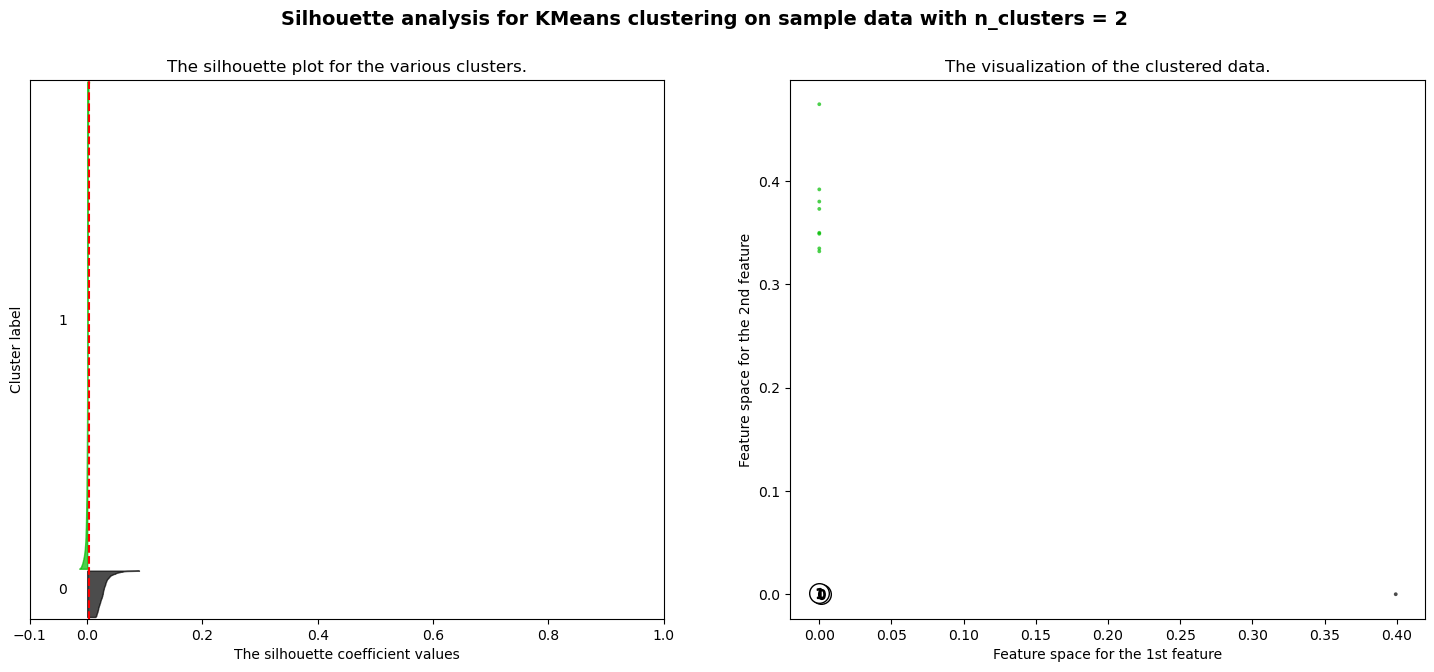

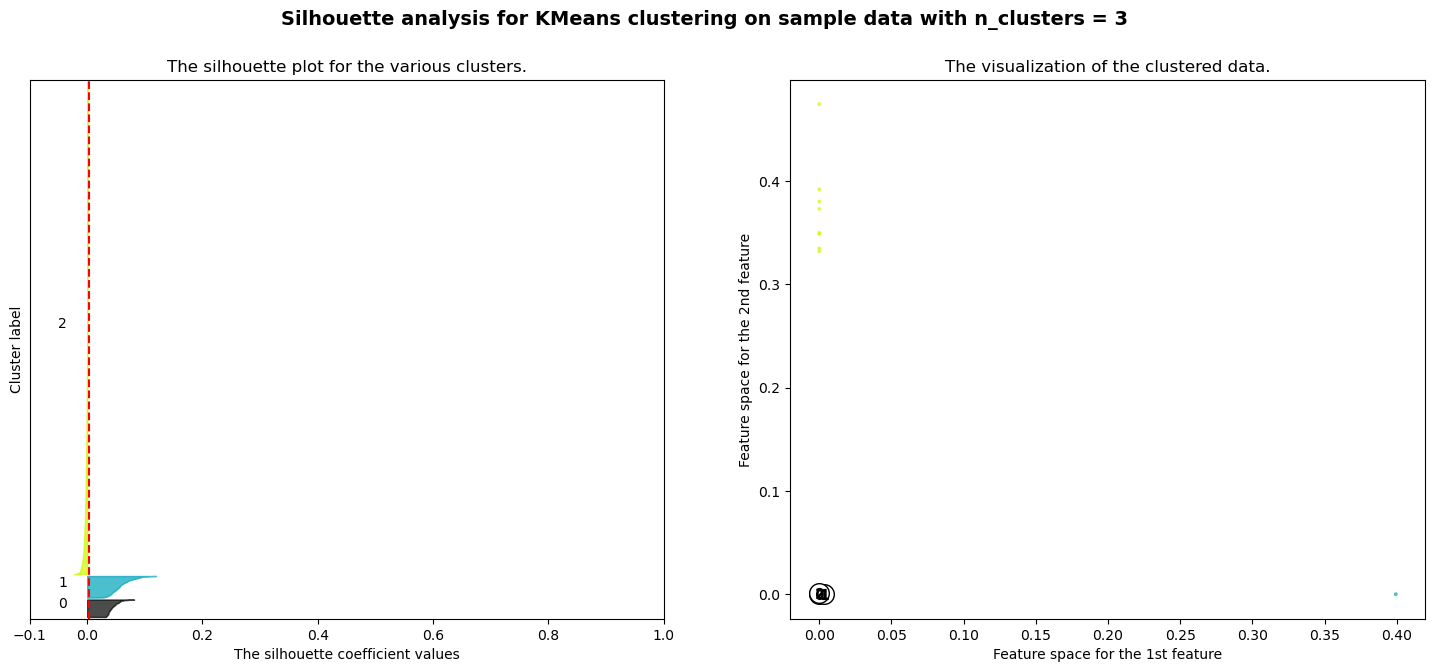

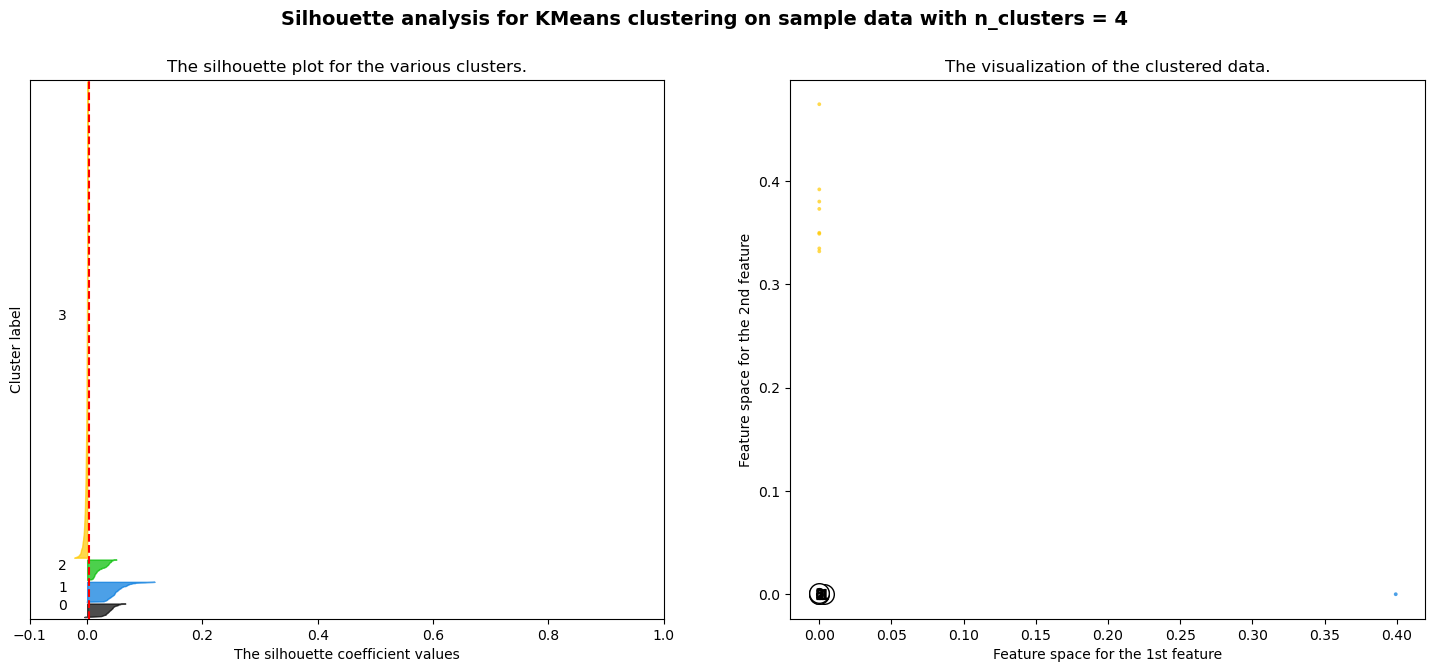

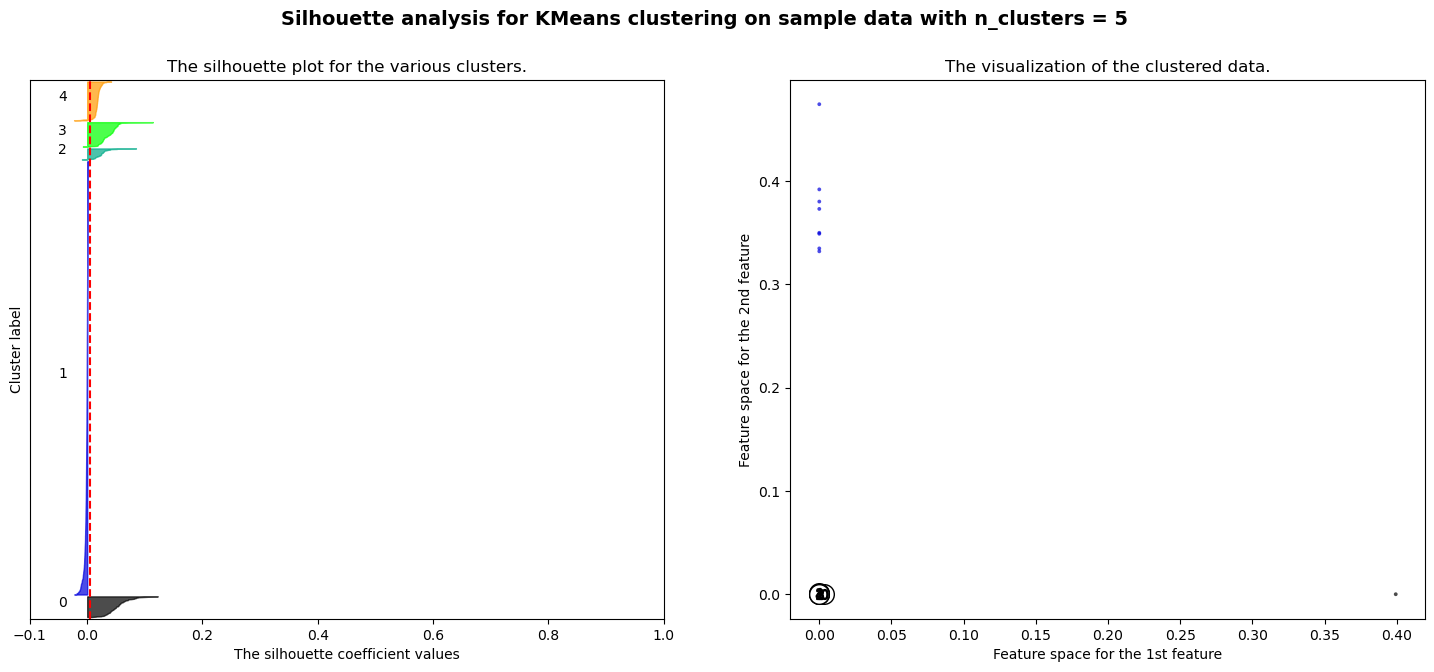

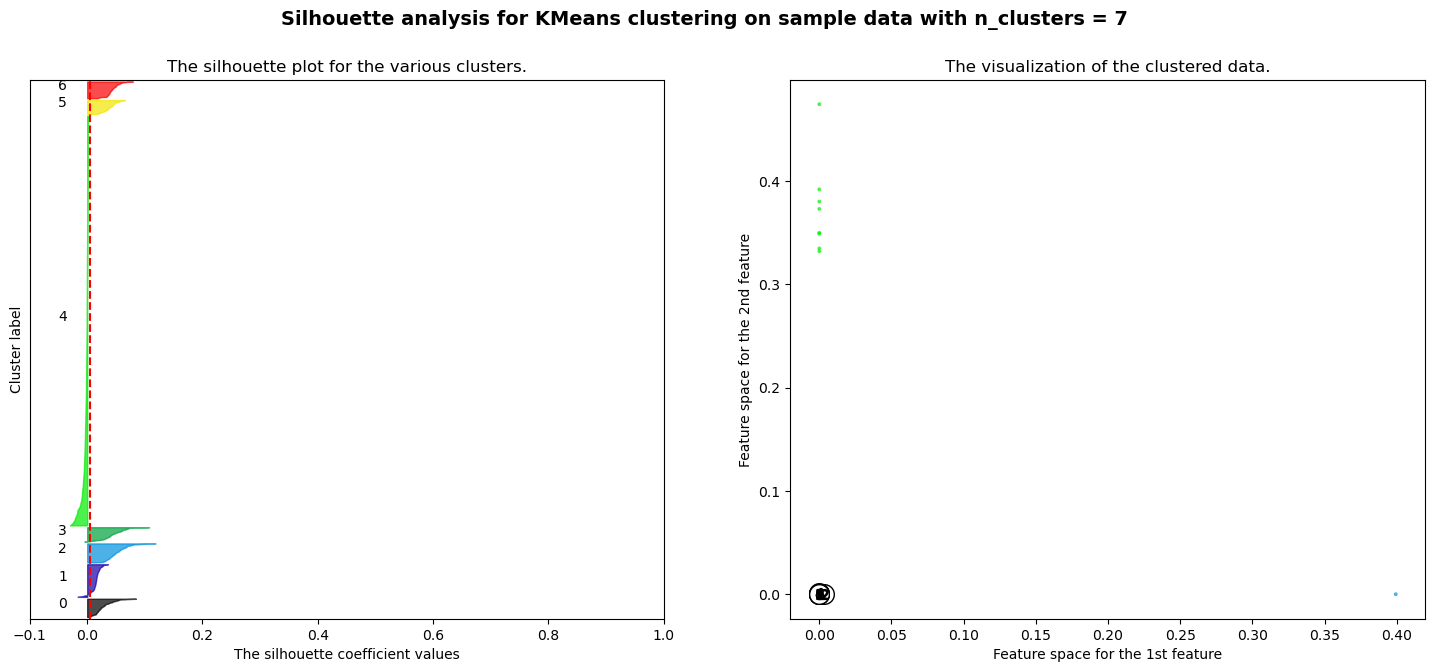

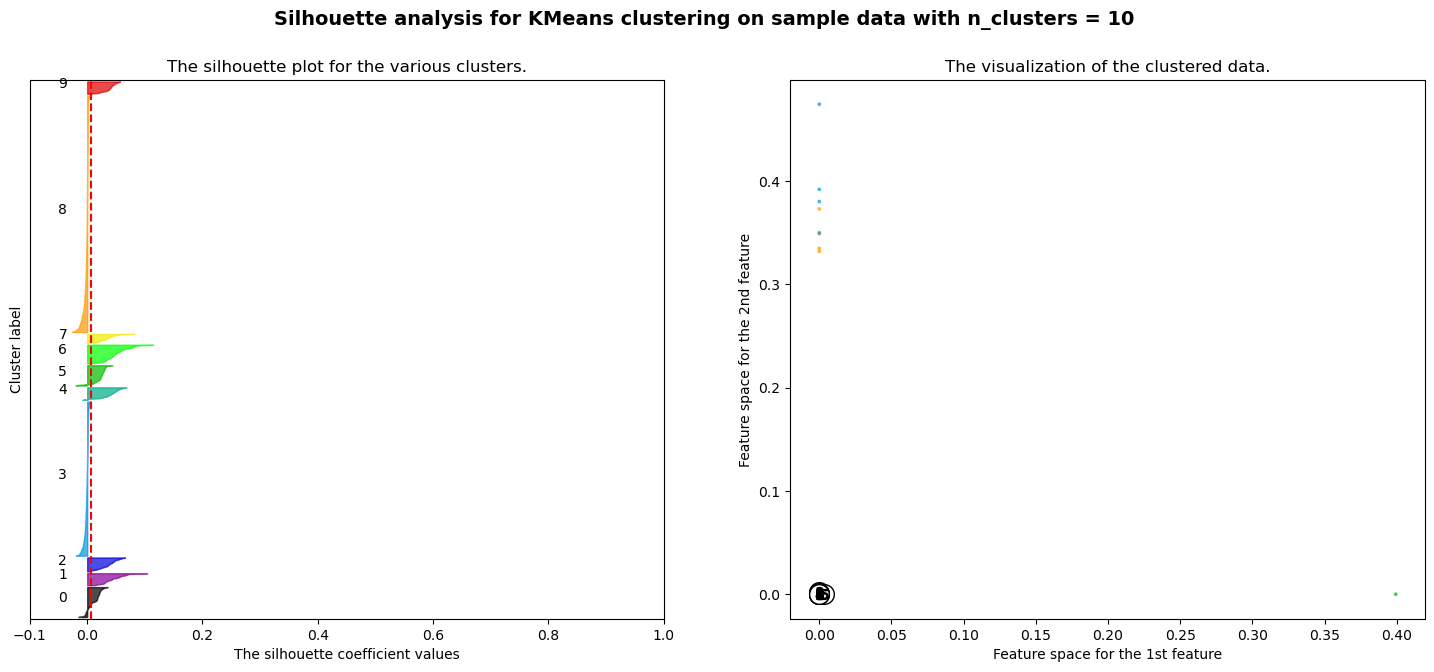

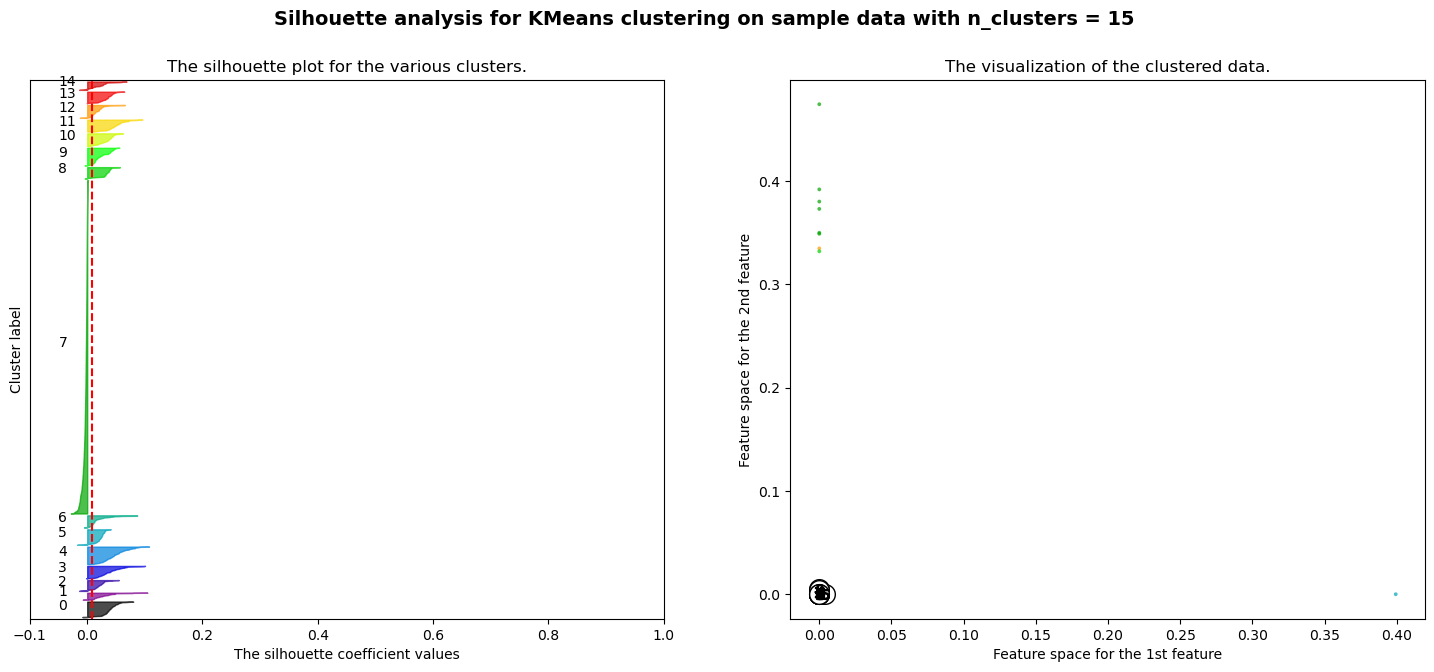

In [9]:
## TF-IDF with KMeans

# Define custom stop words and combine with English stop words
custom_stop_words = news_words = ['news', 'audio', 'listen','watch', 'breaking', 'interview', 'seek', 'cbs', 'weekend']
all_stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# Vectorize the headlines using TF-IDF 
vectorizer = TfidfVectorizer(lowercase=True, stop_words=all_stop_words)
X = vectorizer.fit_transform(df['title'])

X = X.toarray()



range_n_clusters = [2,3,4,5,7,10,15]

silhouettes(X, range_n_clusters)

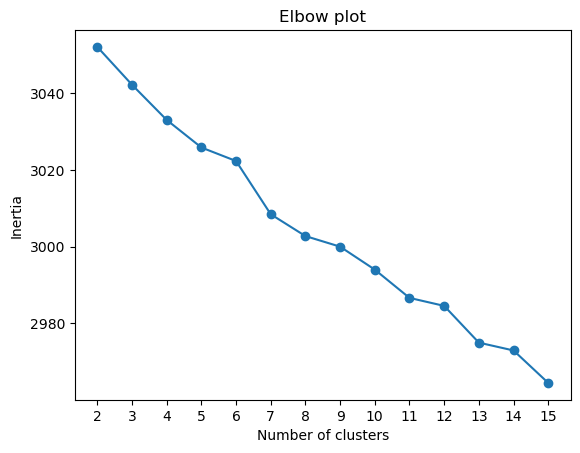

In [10]:
visualize_elbow(X, list(range(2, 16)))

In [11]:
cluster_titles(X,10,df)

Cluster 1:
- Premier League Darts: Build-up to night four in Newcastle
- Caudery achieves 'dream' gold on emotional night
- Premier League Darts: Build-up to night three in Glasgow
- Humphries takes first Premier League night win
- A Night At The Baftas

Cluster 2:
- Scotland v England - where will the game be won?
- All England Open badminton - all you need to know
- Horner says 'time to draw a line under' controversy
- O'Neil set for new Wolves deal talks at end of season
- Hopes rise of new Gaza ceasefire in Egypt talks

Cluster 3:
- Odermatt wins World Cup title with 10 races to go
- Dominant Kerr wins 3000m world indoor title
- GB's Reekie wins world 800m silver in Glasgow
- Ireland's Wiffen wins world 800m freestyle title
- GB's Weston wins skeleton World Championships silver

Cluster 4:
- League One & League Two - live text
- League One & League Two - text updates
- EFL: League One & League Two - live text
- Premier League: Chelsea v Newcastle - team news & build-up
- Premier Le

## One thing we noticed is that a significant number of clusters revolved largely around sports

In [12]:
# Let's look at the categories from bbc URL
df['url'].head(5)

0     https://www.bbc.co.uk/news/world-europe-68273448
1     https://www.bbc.co.uk/news/world-europe-68272233
2    https://www.bbc.co.uk/news/world-us-canada-682...
3    https://www.bbc.co.uk/news/world-middle-east-6...
4    https://www.bbc.co.uk/news/world-us-canada-682...
Name: url, dtype: object

In [13]:
# Let's look at the categories from bbc URL
pd.DataFrame(df['url'].str.split('/').to_list())[3].value_counts()

sport         1775
news          1269
iplayer         20
programmes       7
weather          4
articles         1
newsround        1
Name: 3, dtype: int64

## We decided to split the data into 'Sport' and 'News' categories and then do the analysis on the seperated dataframe.

In [14]:
df['Type_url'] = pd.DataFrame(df['url'].str.split('/').to_list())[3]
df_news = df.loc[df['Type_url'] == 'news']
df_sport = df.loc[df['Type_url'] == 'sport']

## Sport data

For n_clusters = 2 The average silhouette_score is : 0.04276537672796812
For n_clusters = 3 The average silhouette_score is : 0.05044184033445398
For n_clusters = 4 The average silhouette_score is : 0.04491568770324425
For n_clusters = 5 The average silhouette_score is : 0.044045979537763534
For n_clusters = 7 The average silhouette_score is : 0.04406973422655932
For n_clusters = 10 The average silhouette_score is : 0.04764857125583832
For n_clusters = 15 The average silhouette_score is : 0.04584262797958306


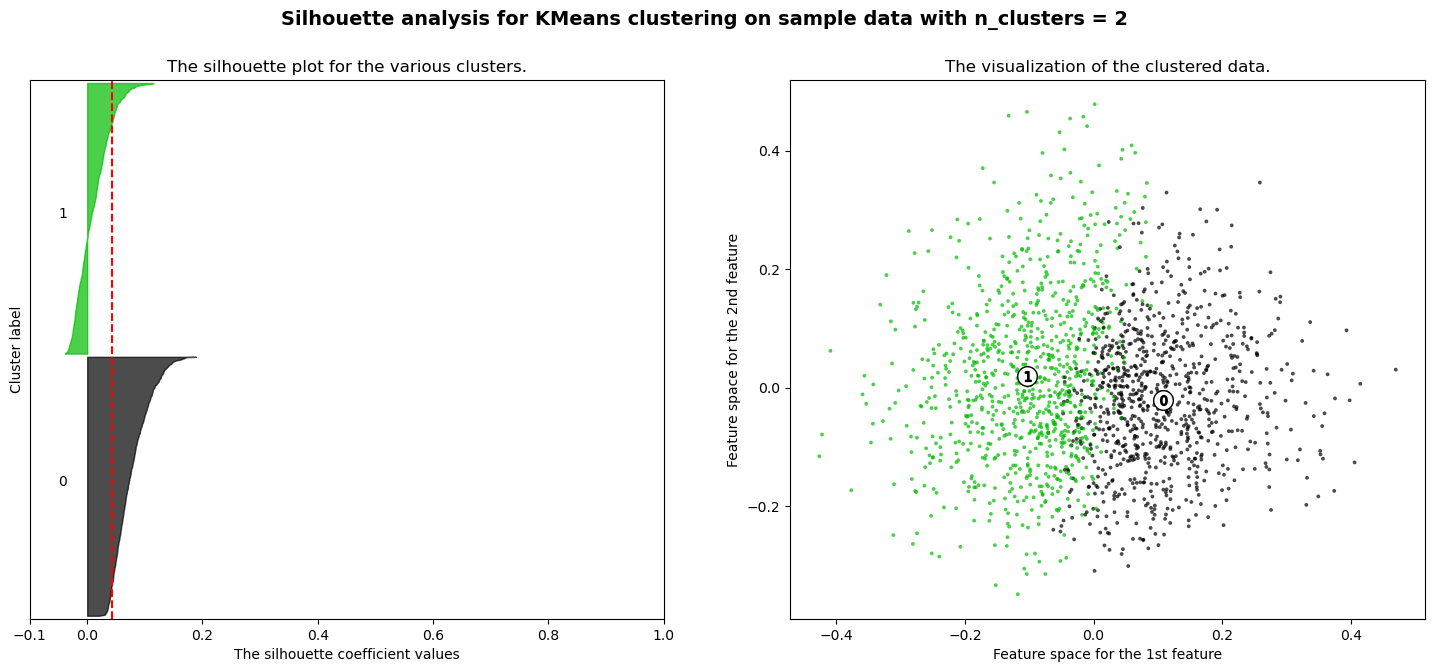

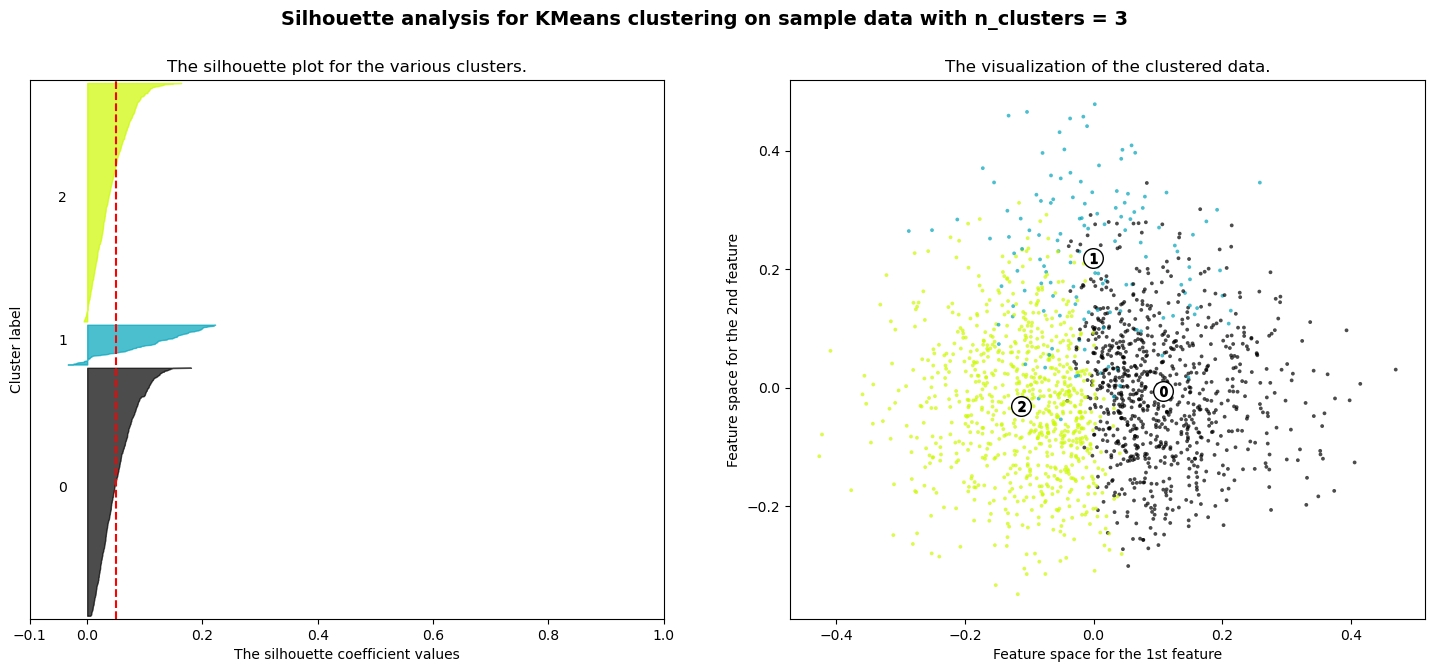

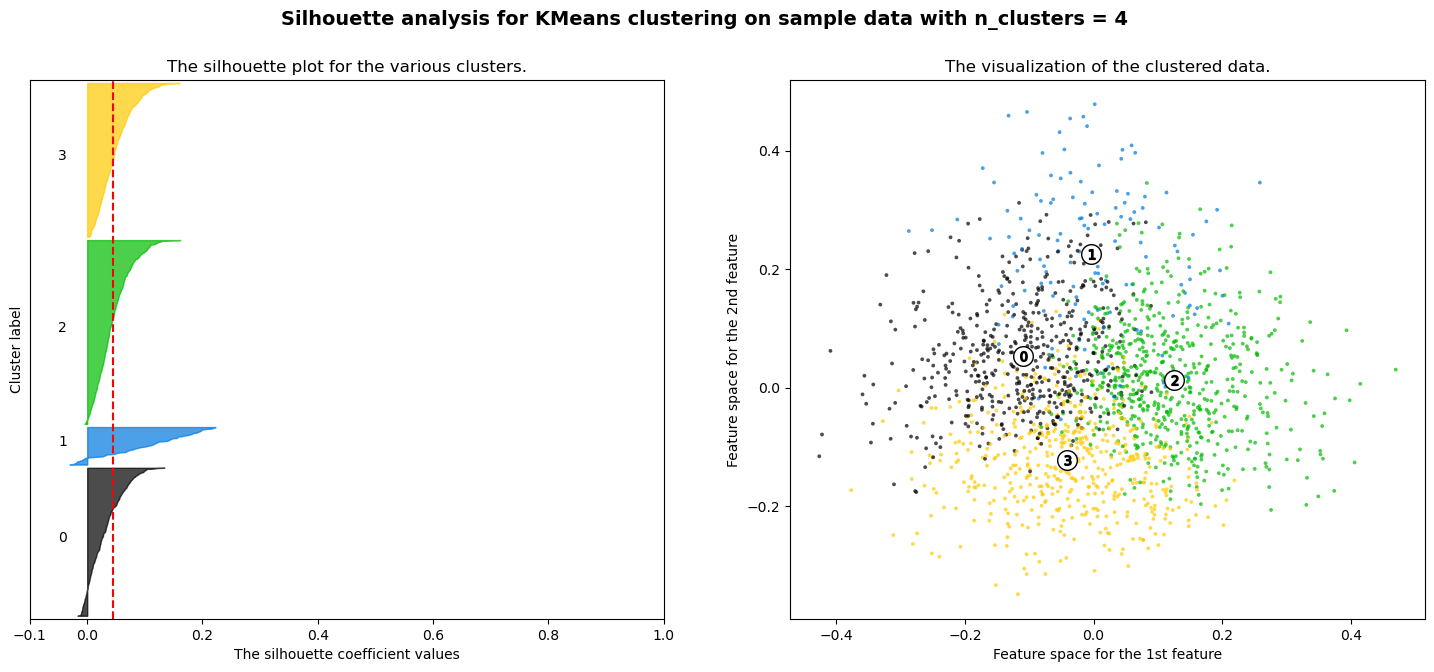

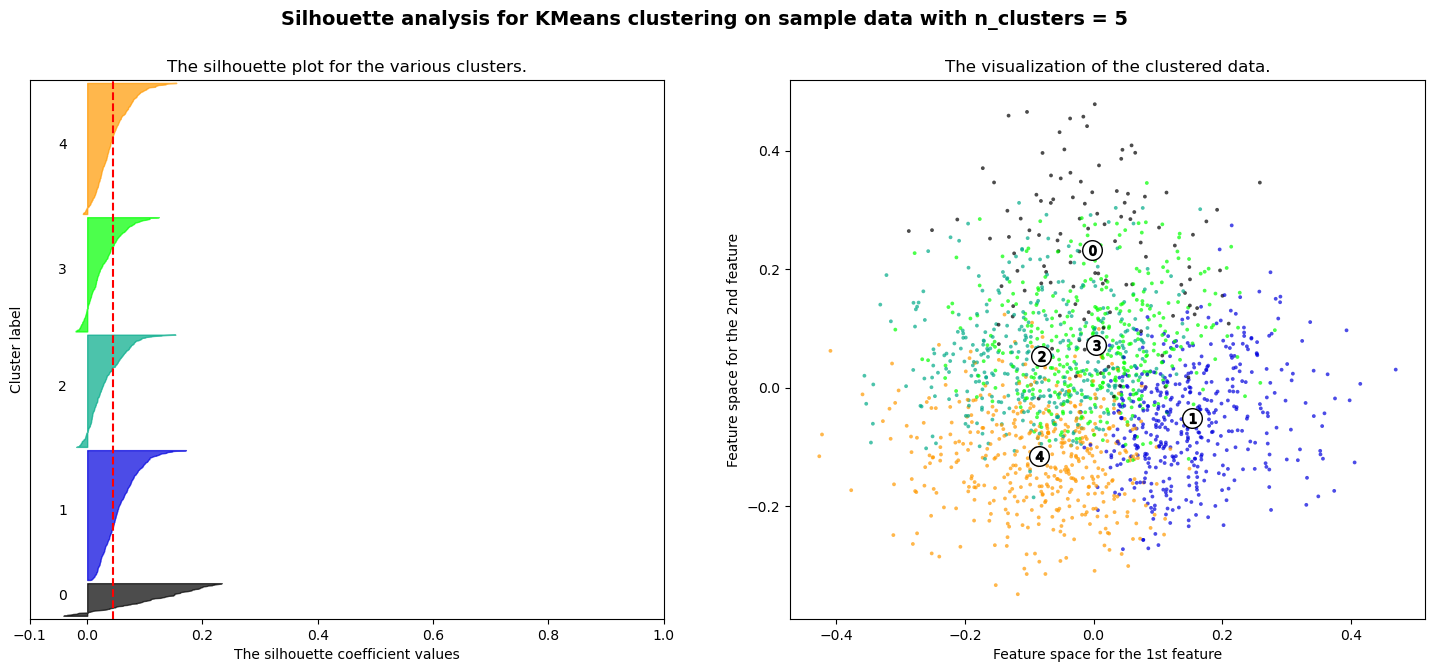

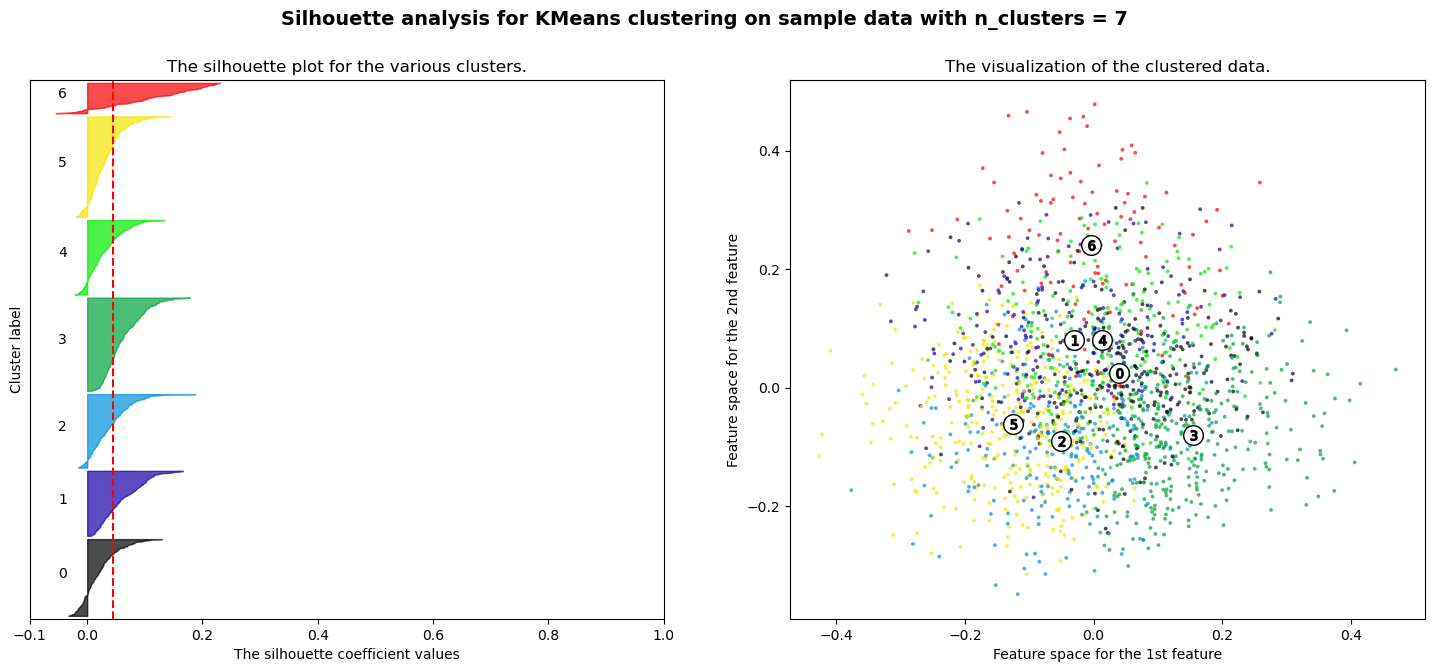

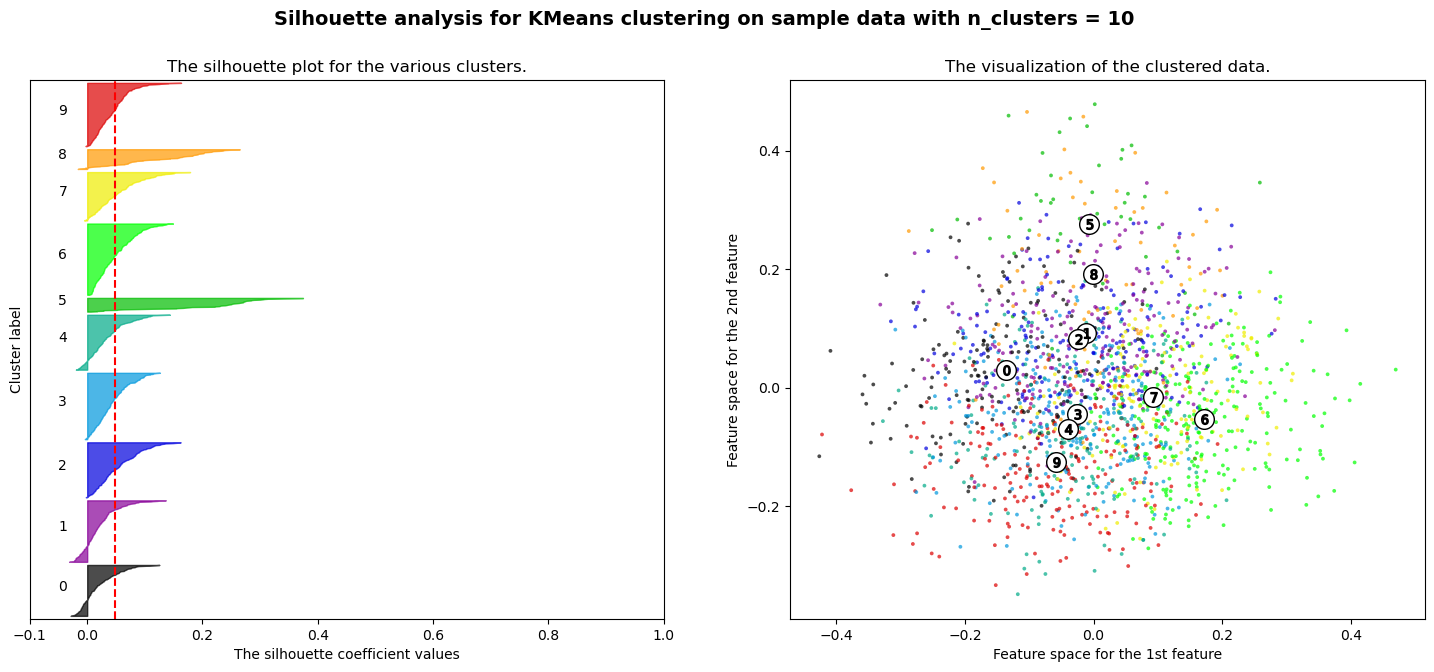

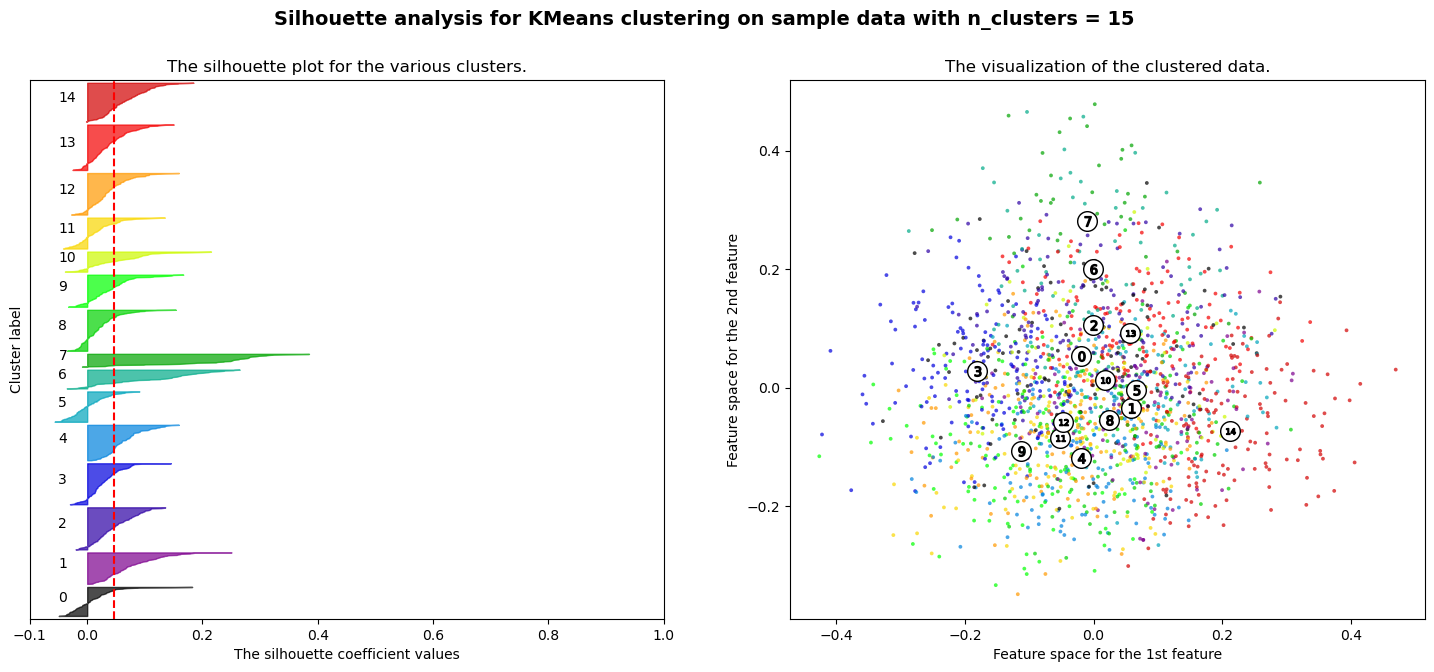

In [15]:
# Define custom stop words and combine with English stop words
custom_stop_words = news_words = ['news', 'audio', 'listen','watch', 'breaking', 'interview', 'seek', 'cbs', 'weekend']
all_stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# Vectorize the headlines using TF-IDF with NLTK stemming
vectorizer = TfidfVectorizer(lowercase=True, stop_words=all_stop_words,tokenizer=custom_tokenizer)
X = vectorizer.fit_transform(df_sport['title'])

X = X.toarray()

pca_30 = PCA(n_components = 30) 
X_pca_30 = pca_30.fit_transform(X)
X_pca_30

range_n_clusters = [2,3,4,5,7,10,15]

silhouettes(X_pca_30, range_n_clusters)

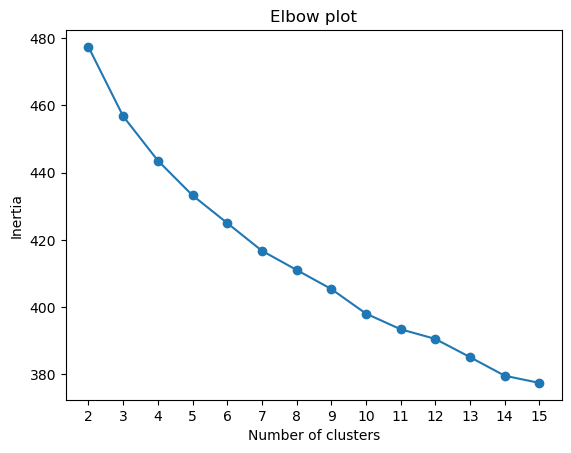

In [16]:
visualize_elbow(X_pca_30, list(range(2, 16)))

In [17]:
cluster_titles(X_pca_30,5,df_sport)

Cluster 1:
- Atkin ends season with World Cup silver
- Does rugby need goal-line technology?
- Abada to miss Kilmarnock game & could leave Celtic on loan
- Take-off change not what long jump needs - Sawyers
- Ten Hag questions Carragher criticism of Man Utd

Cluster 2:
- Almeria set record for longest winless start in La Liga
- Aberdeen v Motherwell & Rangers v Ross County - radio & text
- Electric Rangers extend lead by thrashing Hearts
- Norrie starts Rio defence with victory over Dellien
- Grey will not rule out Wales role as he names squad

Cluster 3:
- Palace performance was for Hodgson - McCarthy
- Son asks South Korea fans to forgive team-mate Lee
- Bulut urges players not to get 'comfortable'
- Who are the top three rugby league to union converts?
- Torquay United to go into administration

Cluster 4:
- PSG striker Mbappe agrees to join Real
- Stokes has 'never seen' anything like Ranchi pitch
- Wales call-up uncapped prop O'Connor
- Leicester beat Bournemouth to progress to qu

For n_clusters = 2 The average silhouette_score is : 0.14833452710394648
For n_clusters = 3 The average silhouette_score is : 0.11854486317846699
For n_clusters = 4 The average silhouette_score is : 0.08600548729234499
For n_clusters = 5 The average silhouette_score is : 0.08628077223648464
For n_clusters = 7 The average silhouette_score is : 0.07424970432601805
For n_clusters = 10 The average silhouette_score is : 0.058721121390345604
For n_clusters = 15 The average silhouette_score is : 0.053811200110609914


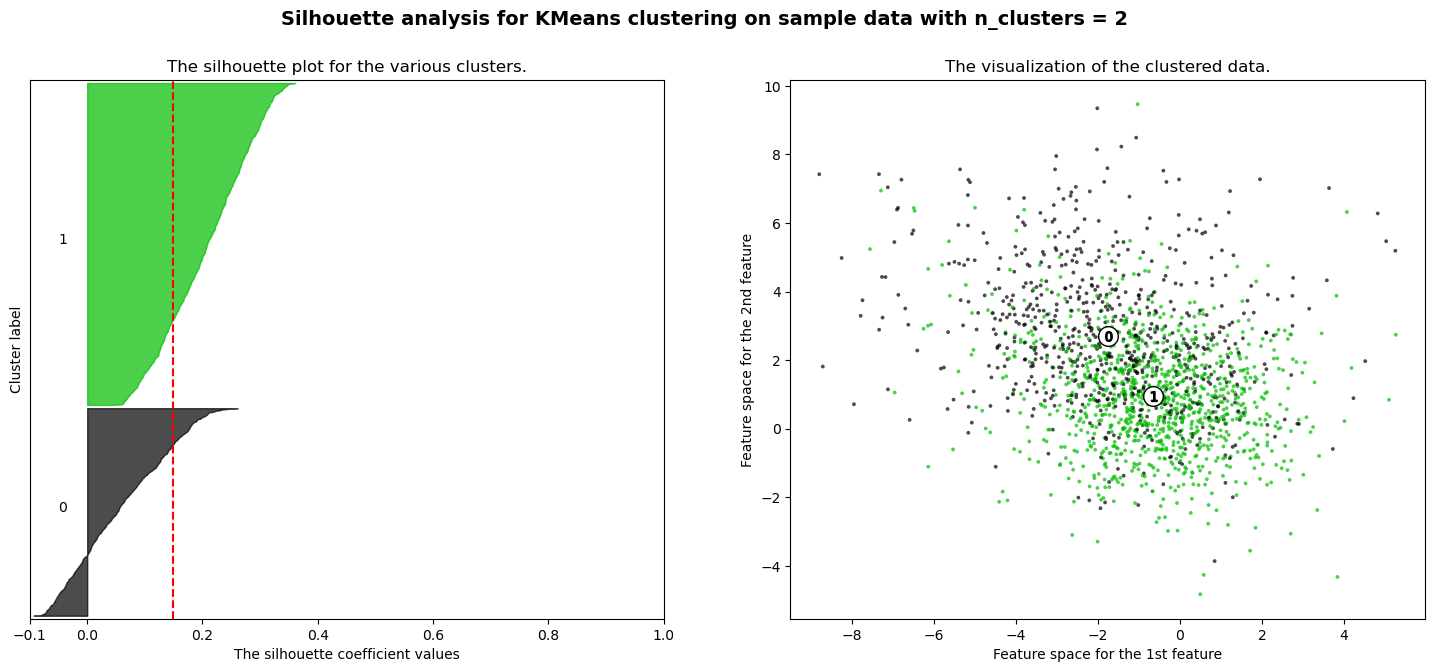

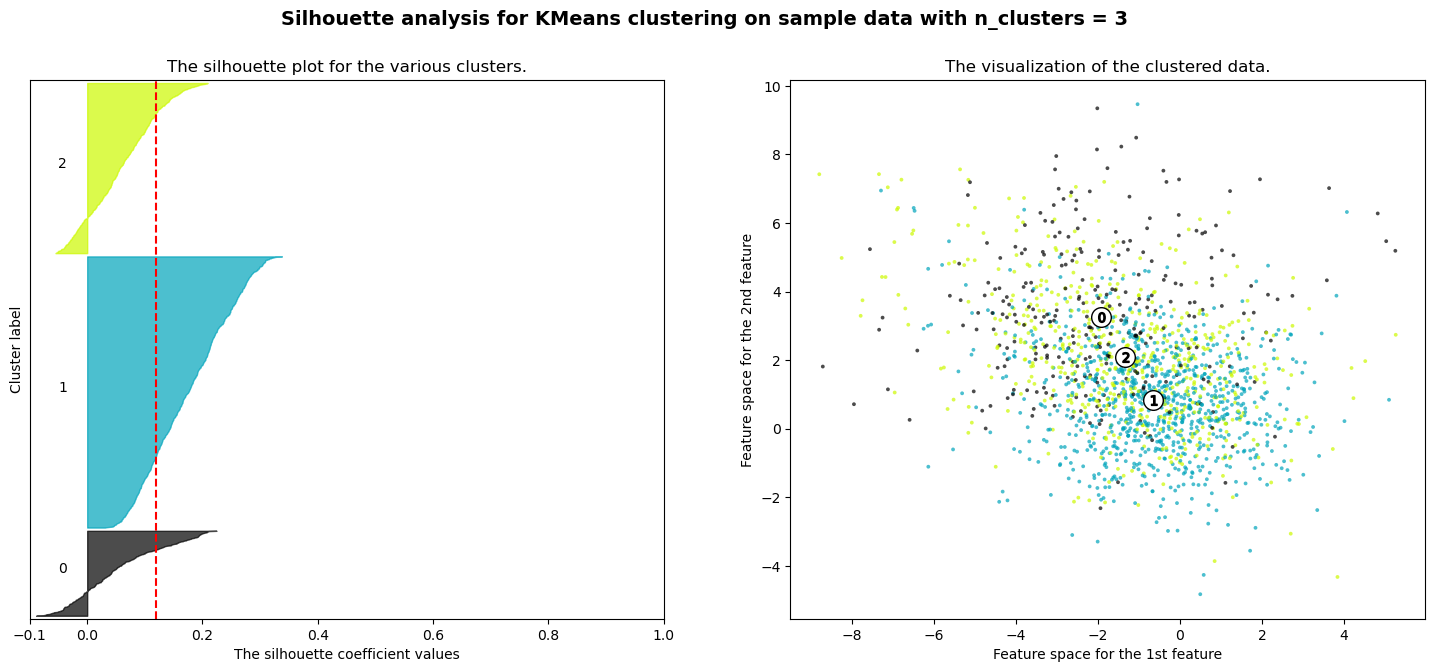

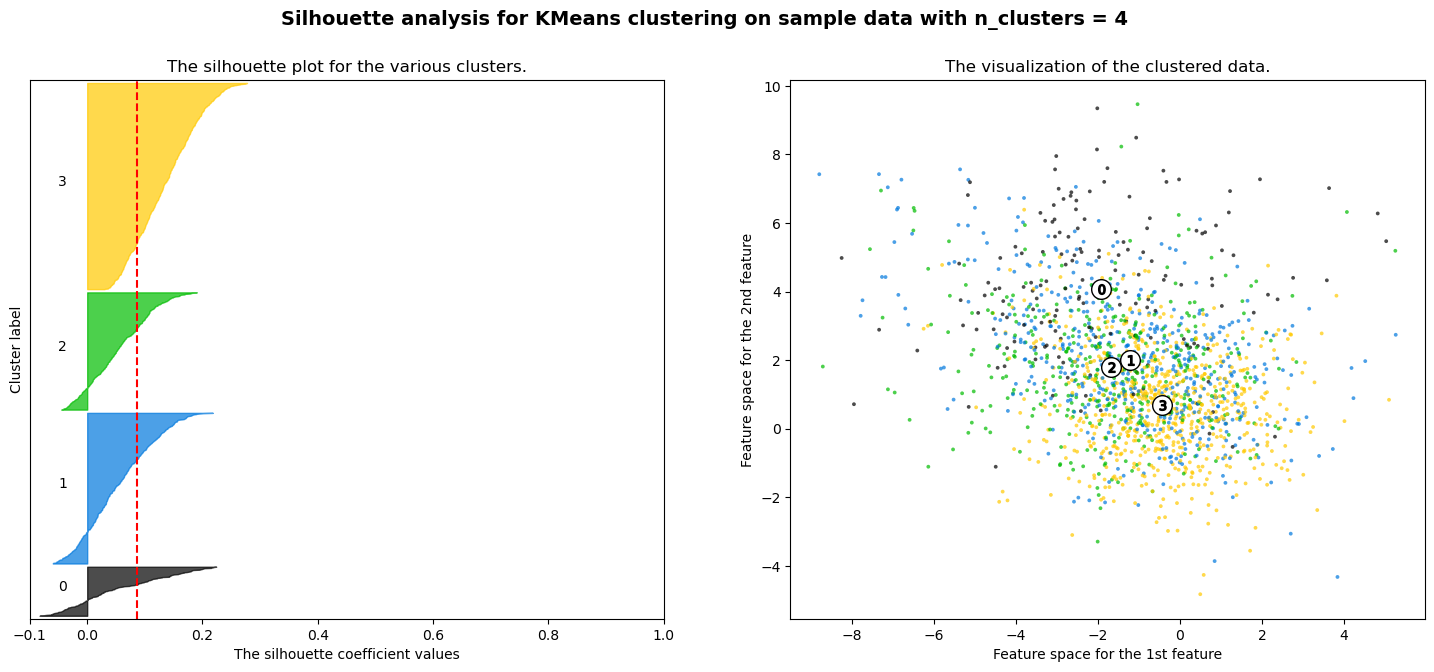

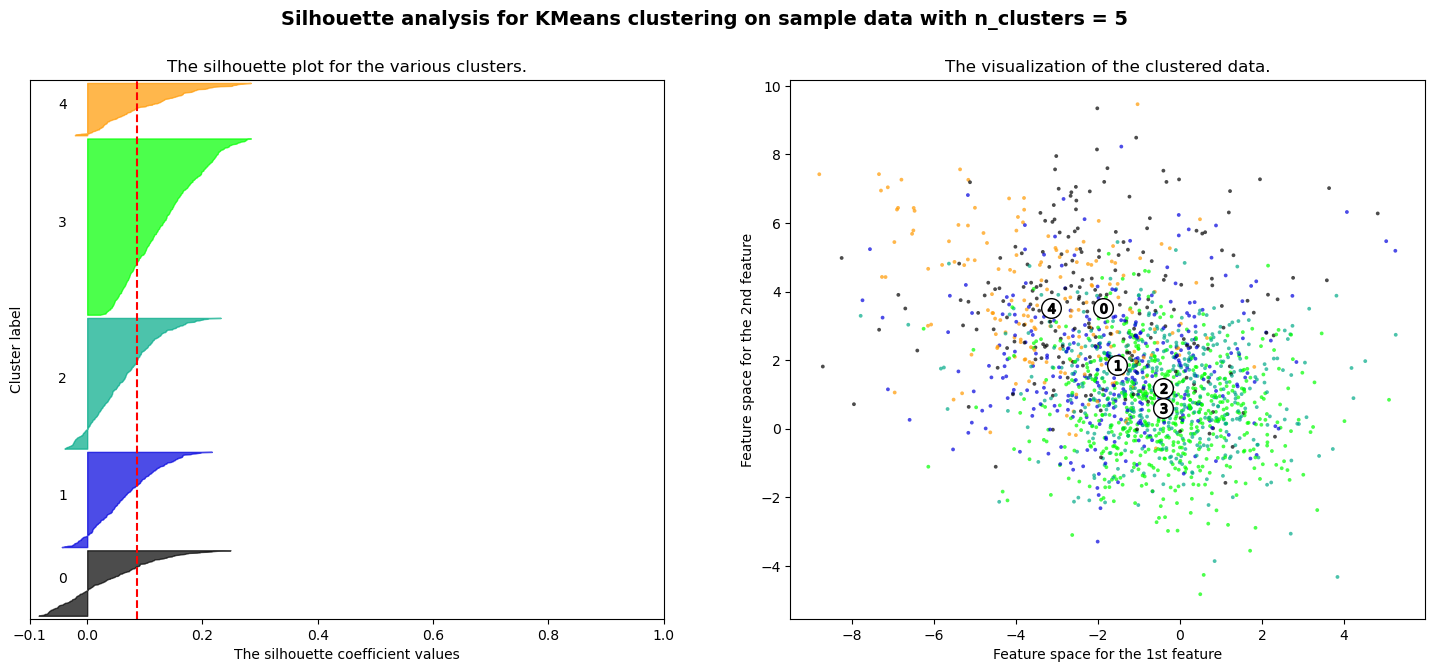

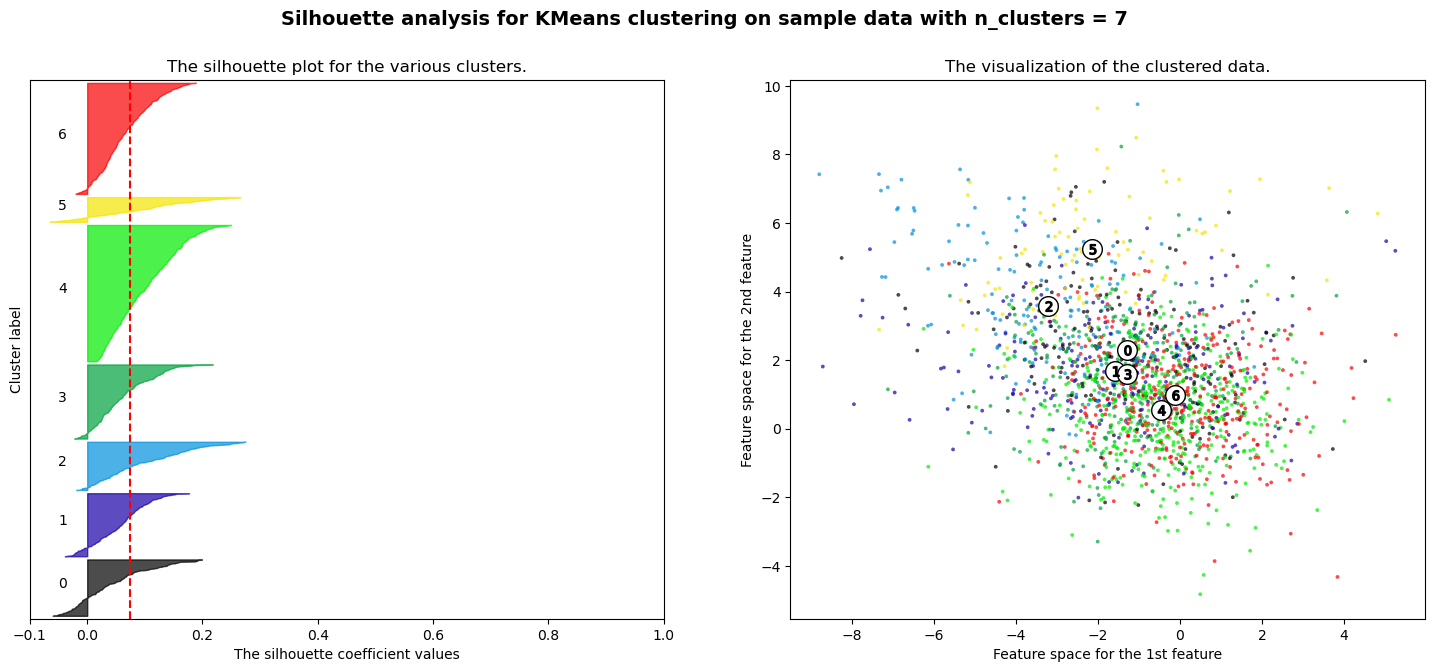

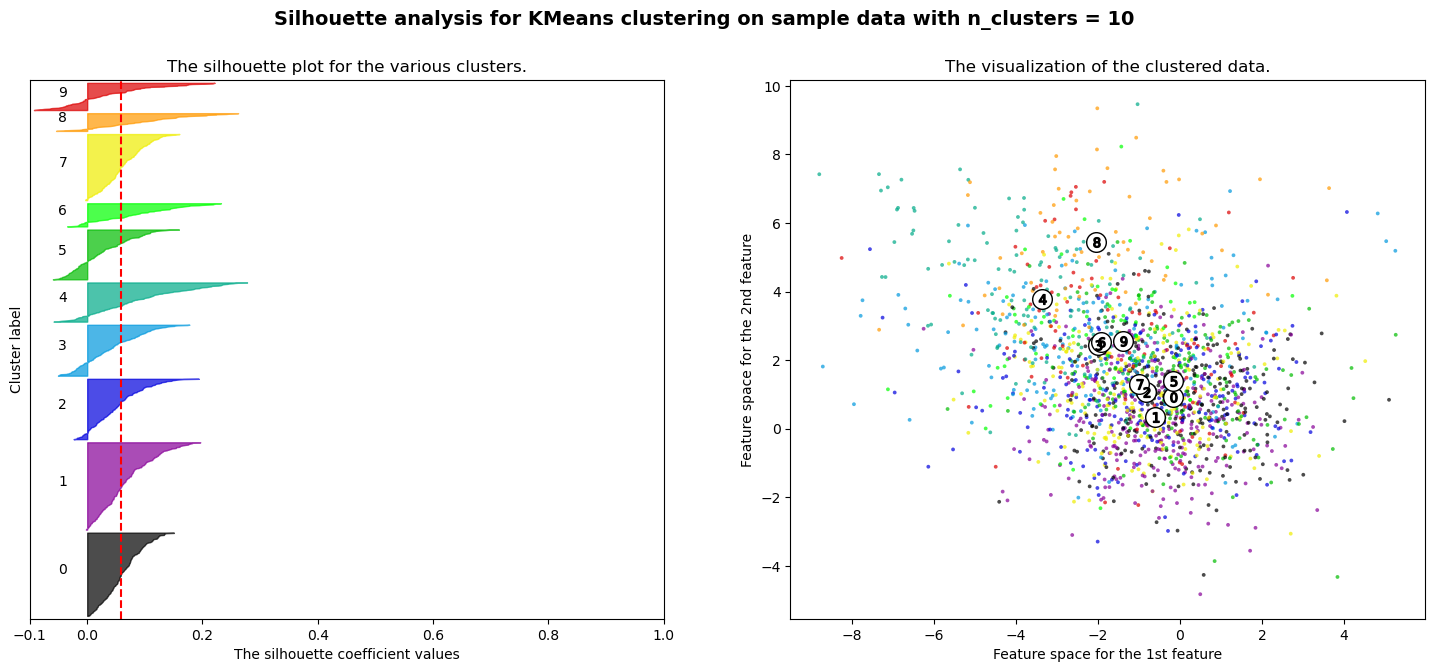

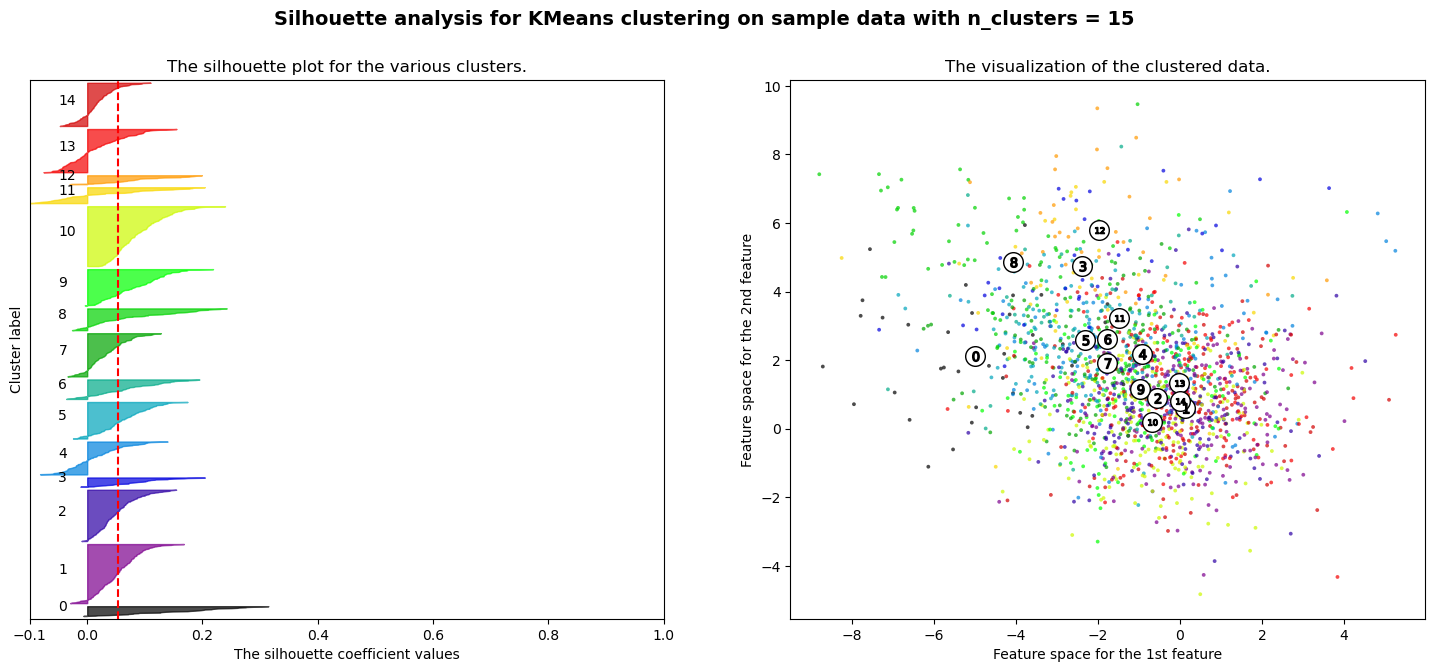

In [18]:
# Embedding 

data = df_sport

# Removing special character
words = express_remove(data) 

# Removing english stop words 
words = stopwords_remove(words)

# Removing choosen words base on context
words = choosenwords_remove(words)

# Applying the embedding
emb = pd.DataFrame(words.apply(map_vectors, axis=1))
emb = pd.DataFrame(emb[0].to_list(), columns=list(range(0,50)))

X = np.array(emb)

range_n_clusters = [2,3,4,5,7,10,15]

silhouettes(X, range_n_clusters)

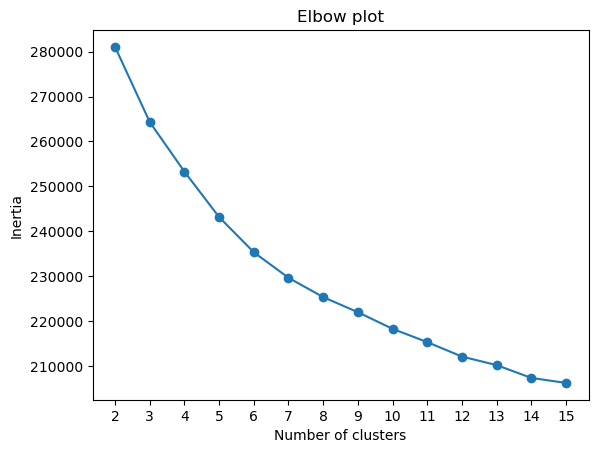

In [19]:
visualize_elbow(X, list(range(2, 16)))

In [20]:
cluster_titles(X,5,df_sport)

Cluster 1:
- Reekie sets record in 800m win
- GB's Whyte clinches BMX Racing World Cup gold
- GB's Weston wins skeleton World Championships silver
- Allen beats Wilson to make semi-finals
- Back on the horse - mankini rider cleared to compete

Cluster 2:
- 'I'm not scared of doing a few silly things' - Meet Larne investor Mike Veeck
- It’s coming, for sure – James talks retirement
- England will rue missed chances, says Vaughan
- NI need no motivation to finish job in play-off - Oxtoby
- 'Cohesive Wales will be a big test for in-form Ireland'

Cluster 3:
- Wigan start season with win at 12-man Castleford
- India v England: Third Test, day two - text updates
- Champions League: Build-up to Lazio v Bayern & PSG v Real Sociedad
- Championship: Third-placed Southampton go to promotion hopefuls West Brom
- Hull KR storm to opening win over 11-man Hull FC

Cluster 4:
- Decisions on my Chelsea future 'not in my hands' - Pochettino
- Alexander-Arnold not forced back too soon - Klopp
- Football

## Sport data conclusion

### Since we are retrieving articles from BBC News, it appears that the top 5 headlines in each cluster are related to British sports events. The majority of which are soccer-related.

### We applied PCA dimensionality reduction to focus on the more important features. The silhouette scores were similar between the PCA and non-PCA methods, however, the scatter plots were easier to visualize. The pre-trained model performed slightly better than our TF-IDF vectorizer. Overall the low average scores indicate that KMeans may not be the most suitable clustering technique for our data.

## News data

For n_clusters = 2 The average silhouette_score is : 0.04020375295829342
For n_clusters = 3 The average silhouette_score is : 0.036342380186096174
For n_clusters = 4 The average silhouette_score is : 0.03555750870518608
For n_clusters = 5 The average silhouette_score is : 0.03062369380719683
For n_clusters = 7 The average silhouette_score is : 0.033035048006050824
For n_clusters = 10 The average silhouette_score is : 0.03676774010383878
For n_clusters = 15 The average silhouette_score is : 0.037421946914657715


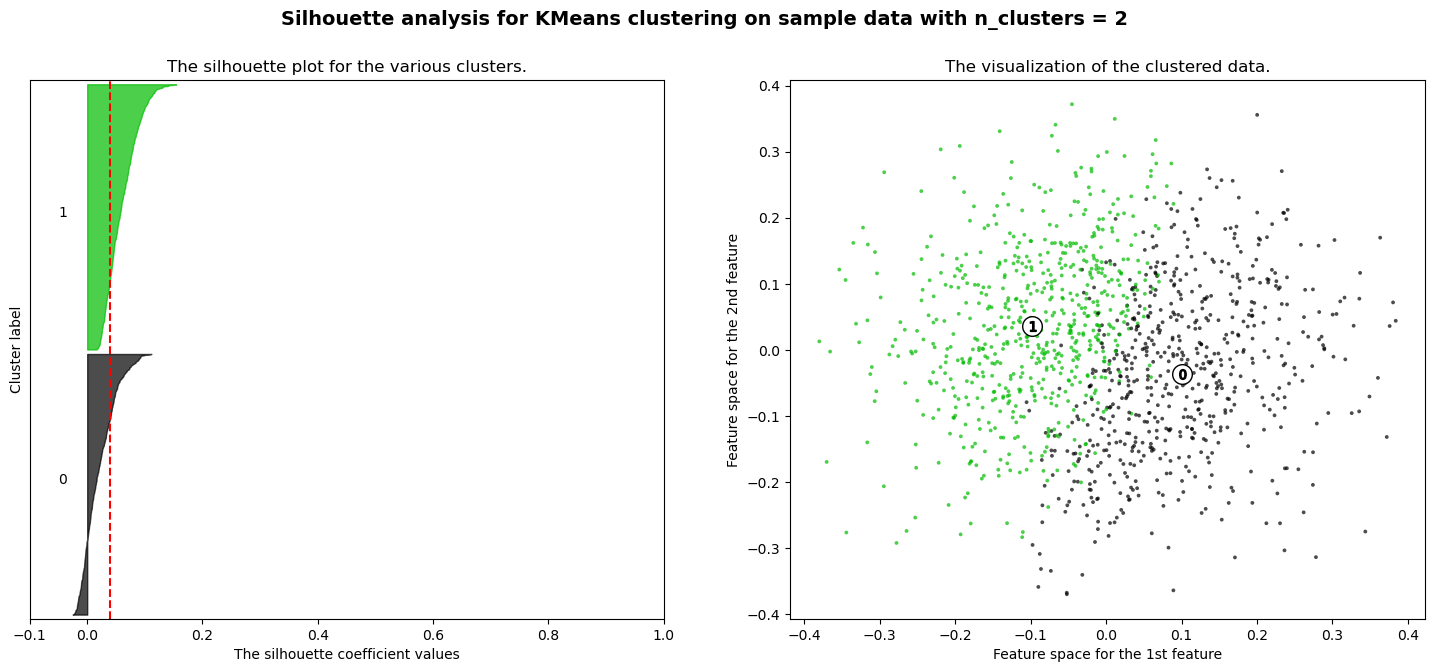

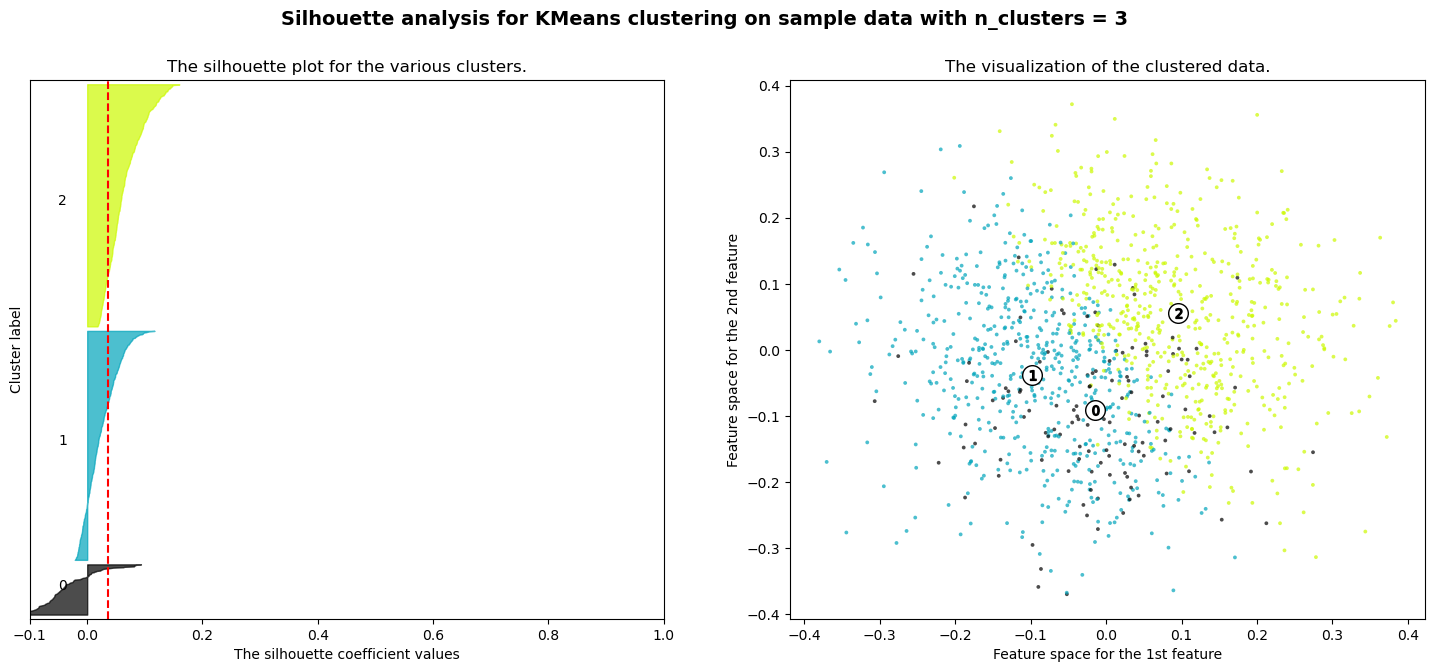

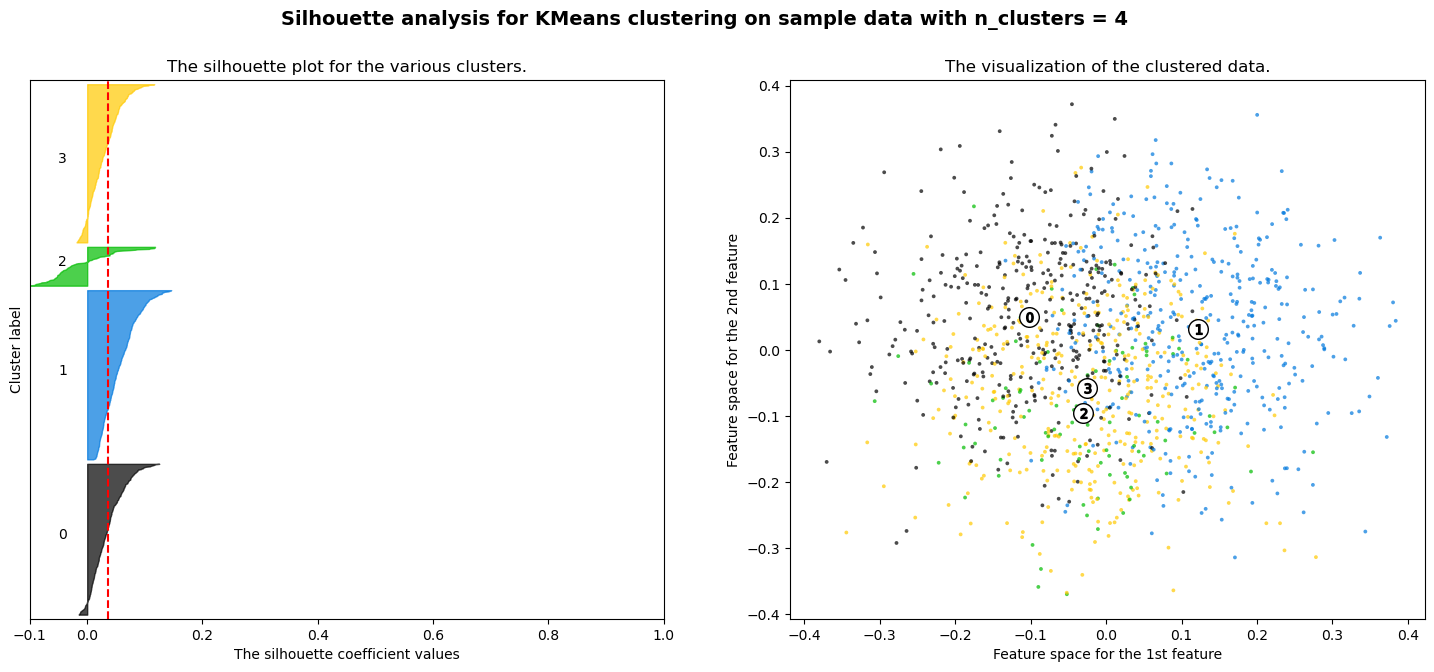

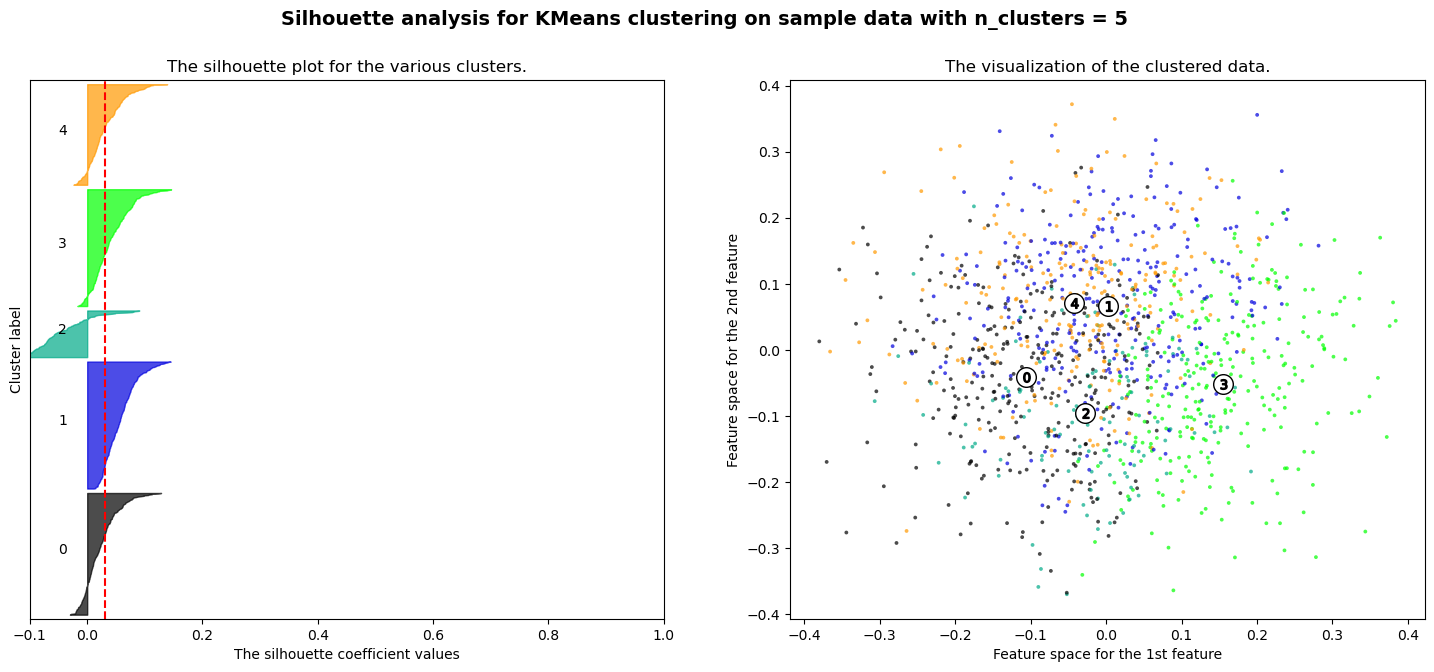

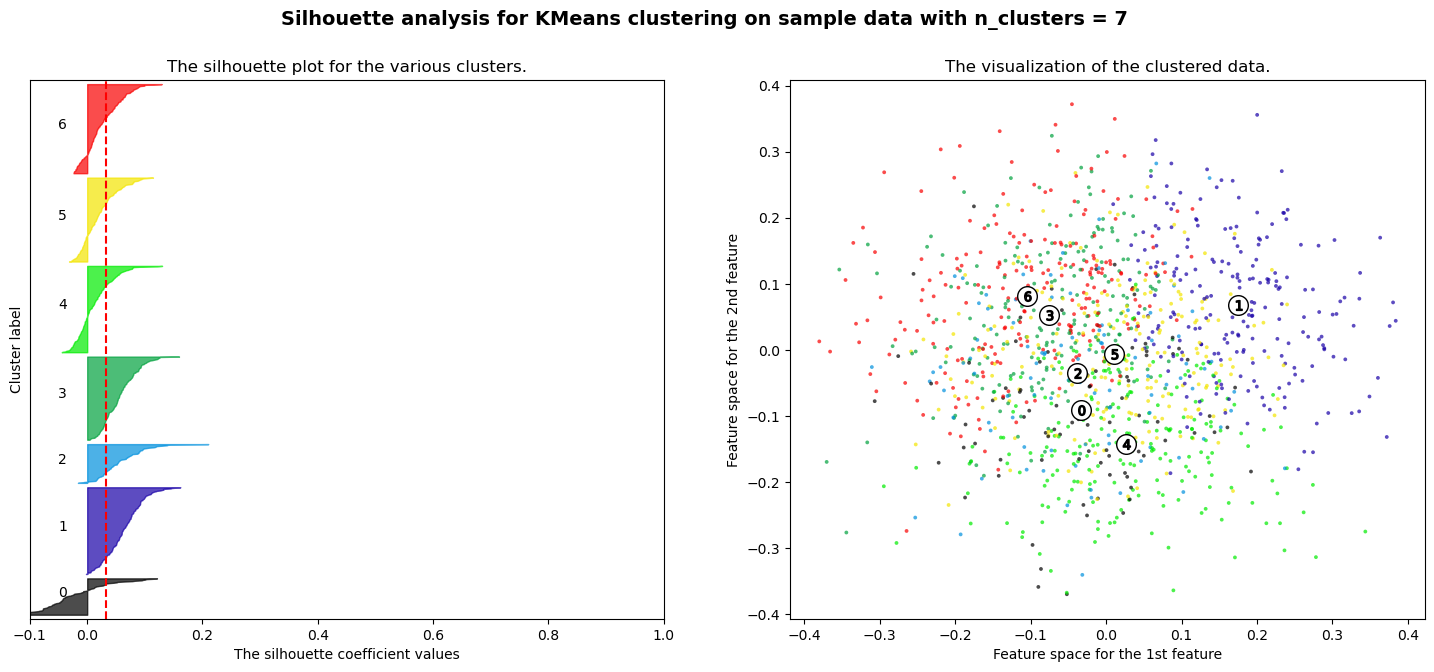

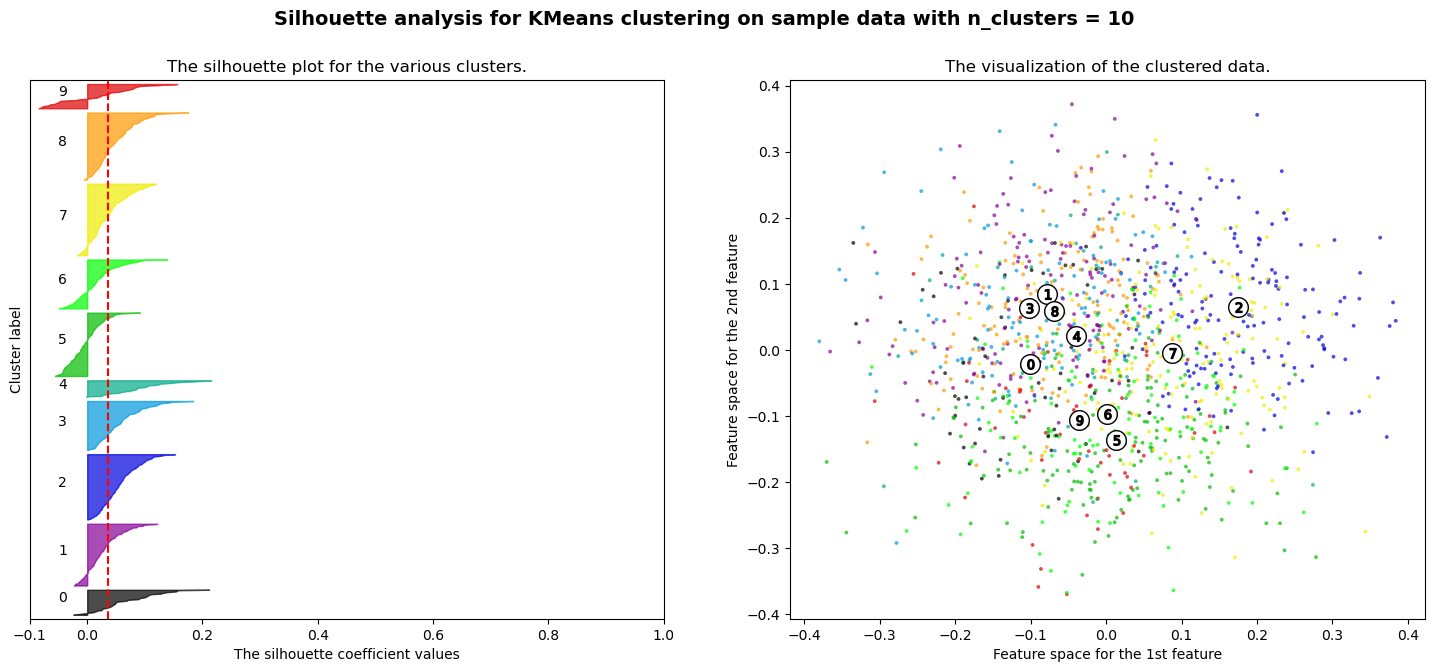

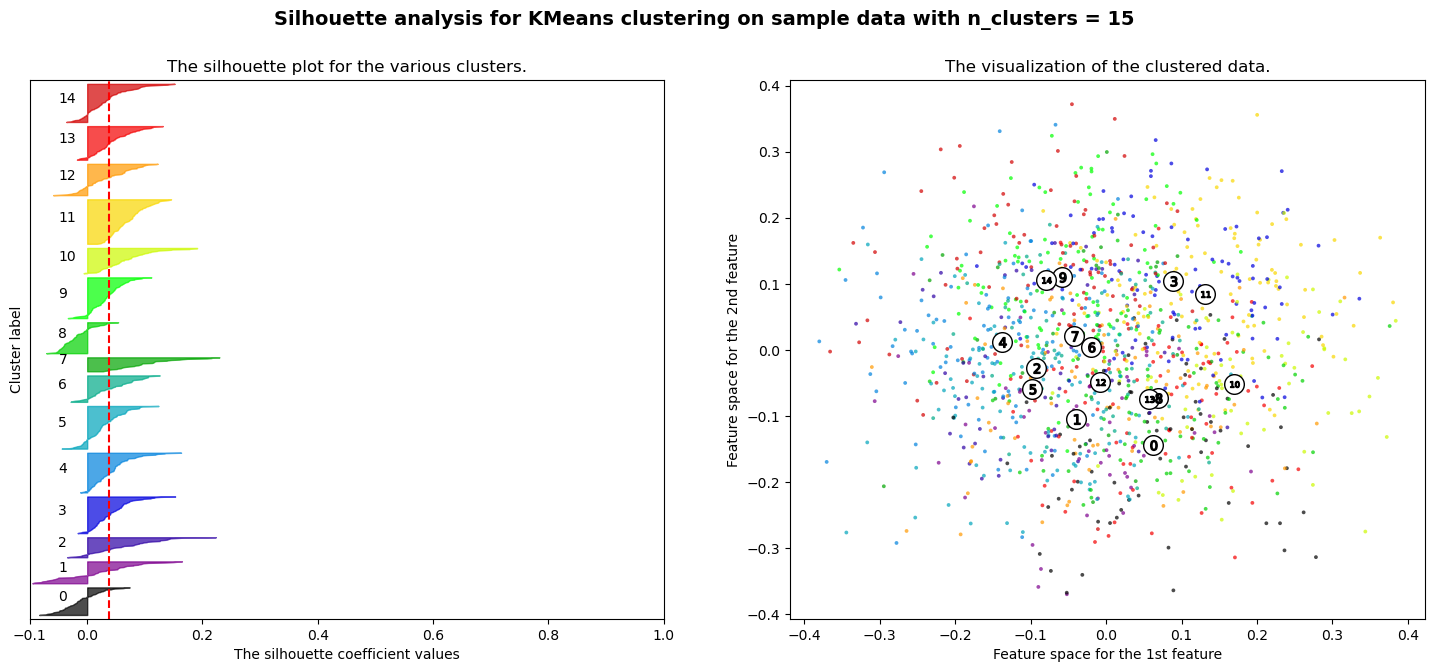

In [21]:
# Define custom stop words and combine with English stop words
custom_stop_words = news_words = ['news', 'audio', 'listen','watch', 'breaking', 'interview', 'seek', 'cbs', 'weekend']
all_stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# Vectorize the headlines using TF-IDF with NLTK stemming
vectorizer = TfidfVectorizer(lowercase=True, stop_words=all_stop_words,tokenizer=custom_tokenizer)
X = vectorizer.fit_transform(df_news['title'])

X = X.toarray()

pca_50 = PCA(n_components = 50)
X_pca_50 = pca_50.fit_transform(X)
X_pca_50

range_n_clusters = [2,3,4,5,7,10,15]

silhouettes(X_pca_50, range_n_clusters)

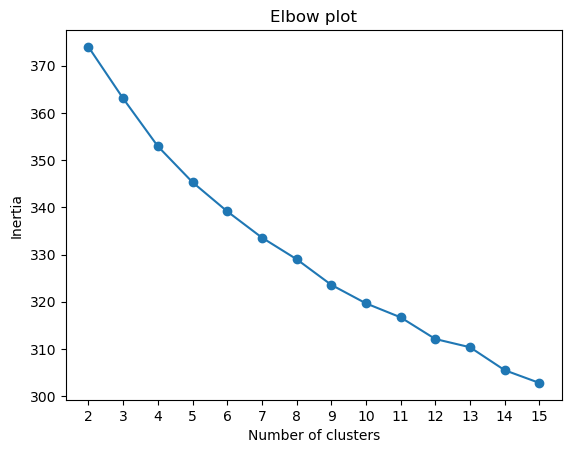

In [22]:
visualize_elbow(X_pca_50, list(range(2, 16)))

In [23]:
cluster_titles(X_pca_50,5,df_news)

Cluster 1:
- Indonesia election: Who are the presidential candidates?
- Germany unveils measures to tackle far-right surge
- Major search after reports child, 3, fell into river
- Starmer demands answers about BBC Horizon story
- 'Schools phone ban' and Kremlin 'covering tracks'

Cluster 2:
- Cornish patients visit NHS dentist in Wiltshire - 200 miles away
- Company 'commits' to town despite 100 job losses
- Ex-officer will not be prosecuted over 10 murders
- Donald Trump launches own-brand shoes after $355m court blow
- Baftas 2024: Hollywood stars light up red carpet

Cluster 3:
- Families of disabled people tell BBC of battle for NHS care support
- Labour MPs face key decision as Gaza ceasefire vote looms
- 'Oppenhomies' Murphy and Downey Jr scoop Baftas
- AU chief urges more action on Africa instability
- Indonesia hit by some of strongest winds recorded

Cluster 4:
- Russia developing 'troubling' anti-satellite weapon - US
- 'Zombie' fires burn under the snow and soil in Canada
- 

For n_clusters = 2 The average silhouette_score is : 0.09532412674442156
For n_clusters = 3 The average silhouette_score is : 0.06981309320088705
For n_clusters = 4 The average silhouette_score is : 0.06107676285911663
For n_clusters = 5 The average silhouette_score is : 0.06130875224257239
For n_clusters = 7 The average silhouette_score is : 0.0595353264181516
For n_clusters = 10 The average silhouette_score is : 0.05777111620308097
For n_clusters = 15 The average silhouette_score is : 0.05354338782161258


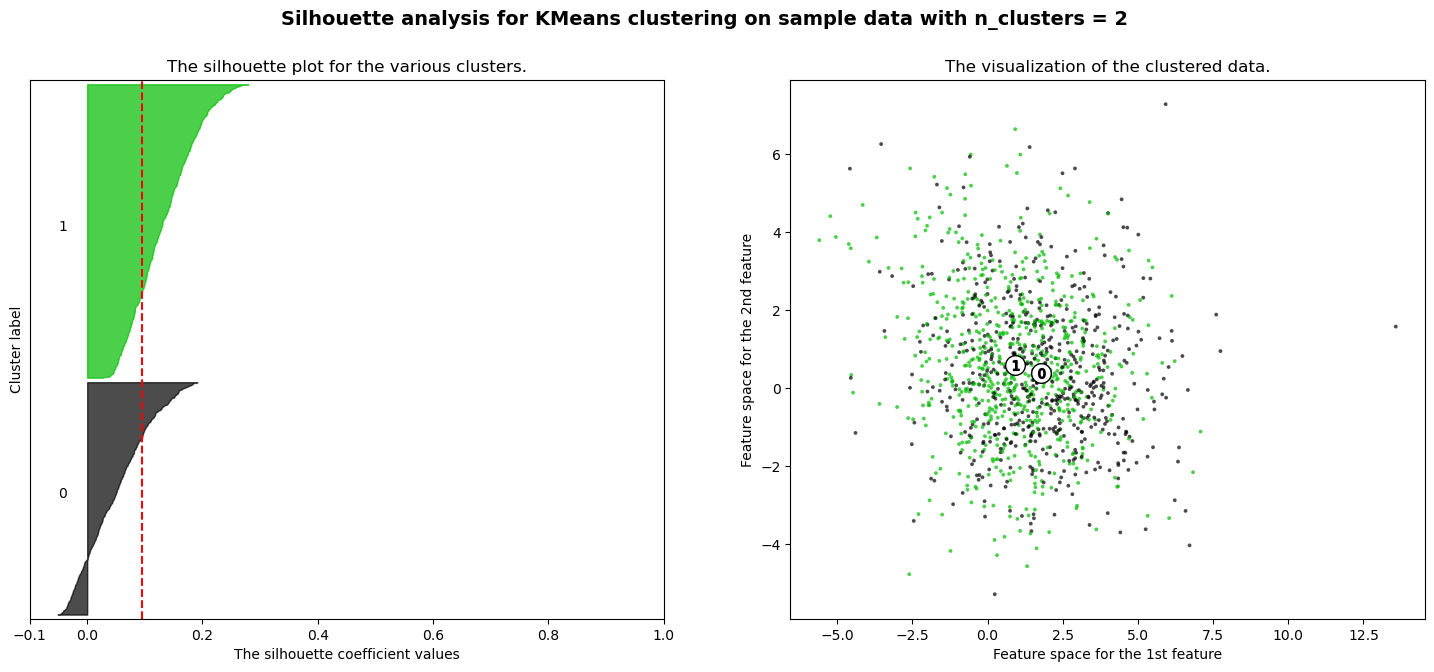

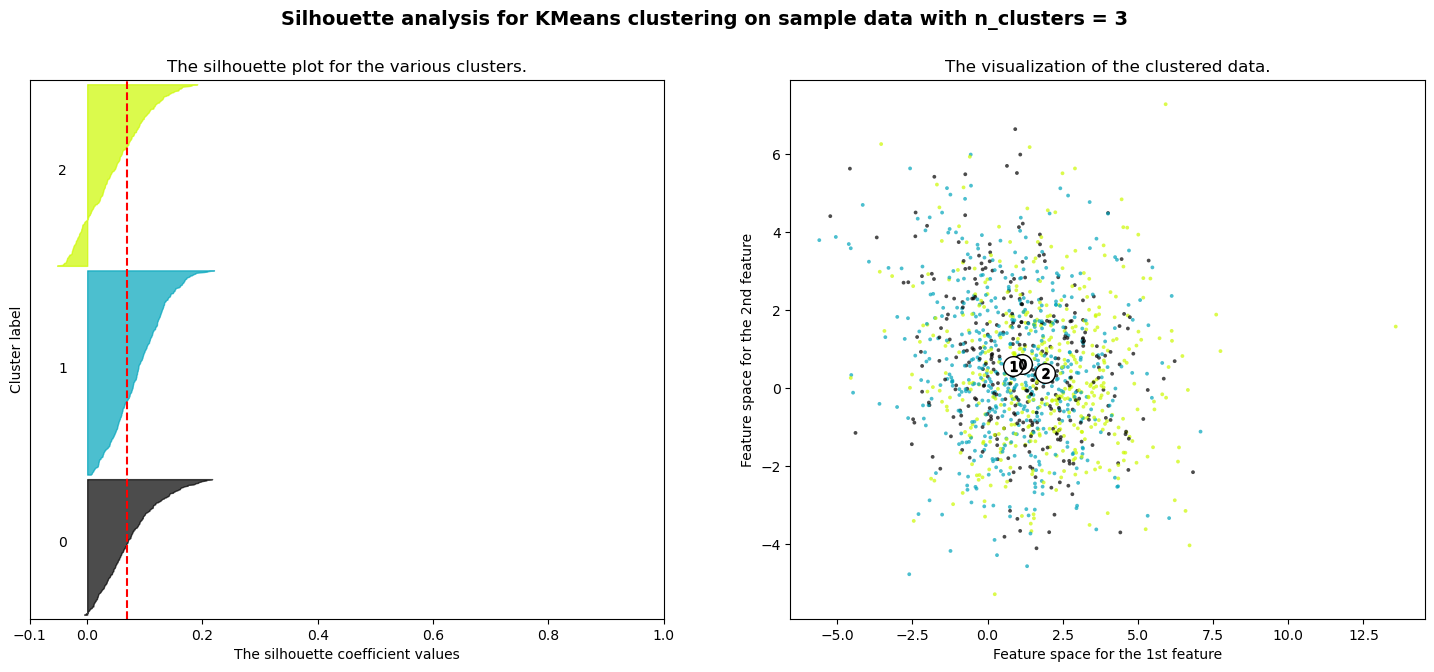

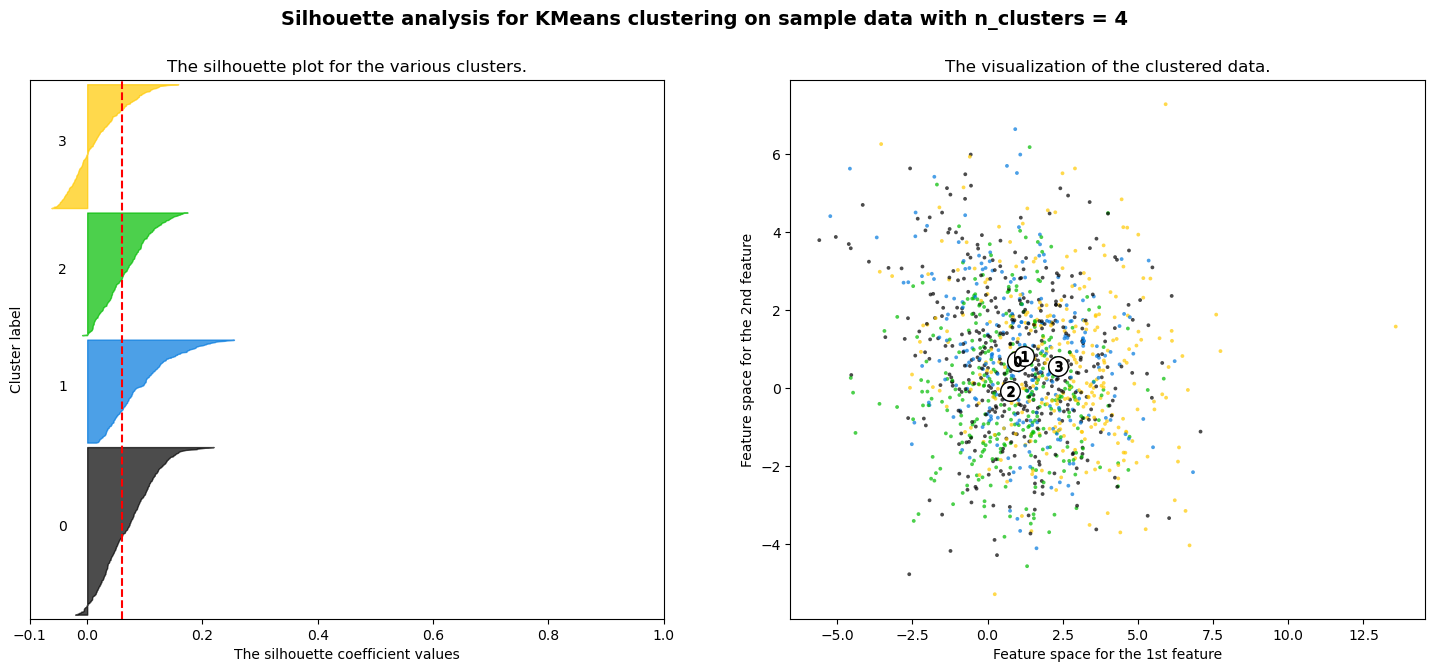

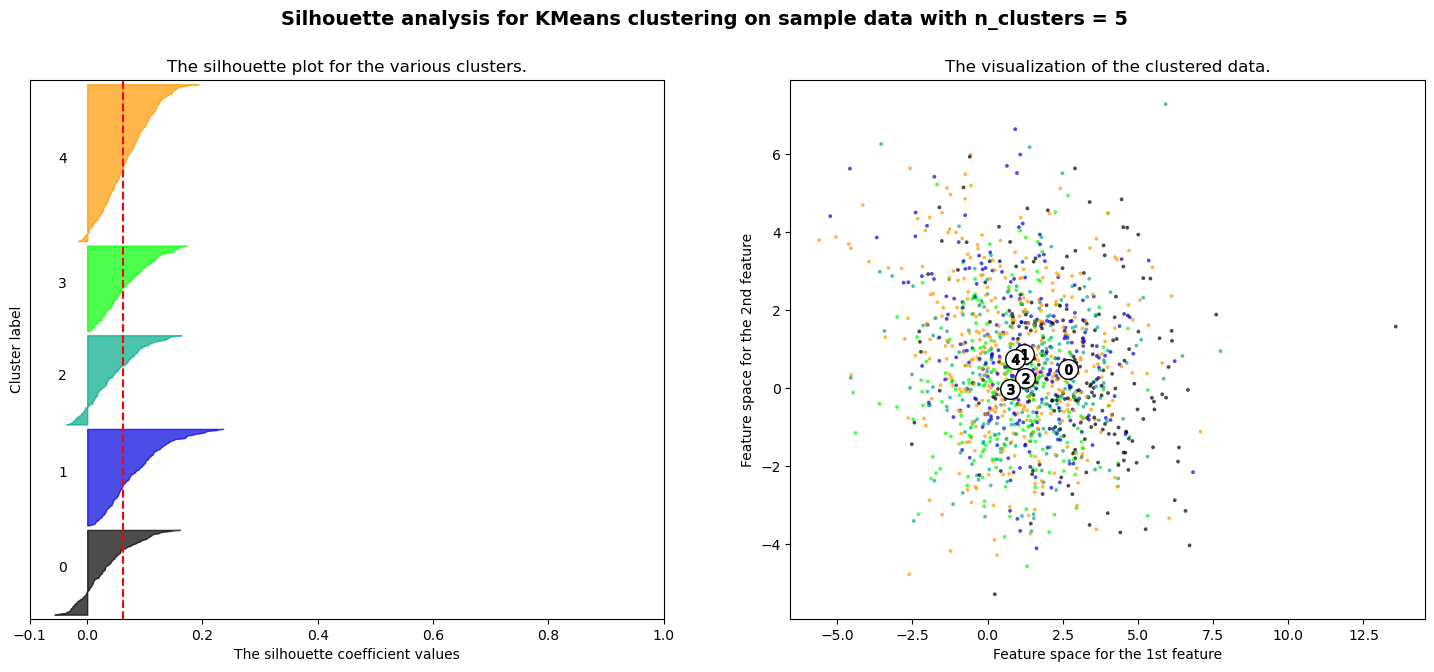

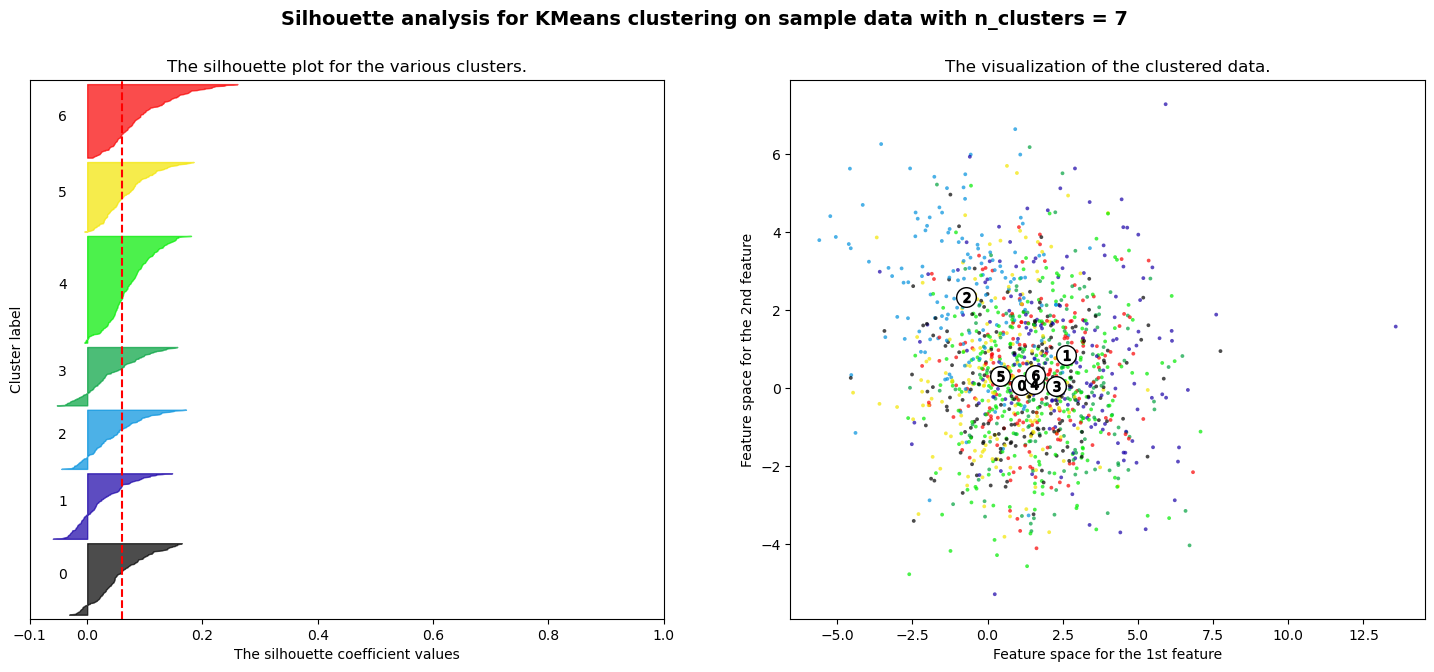

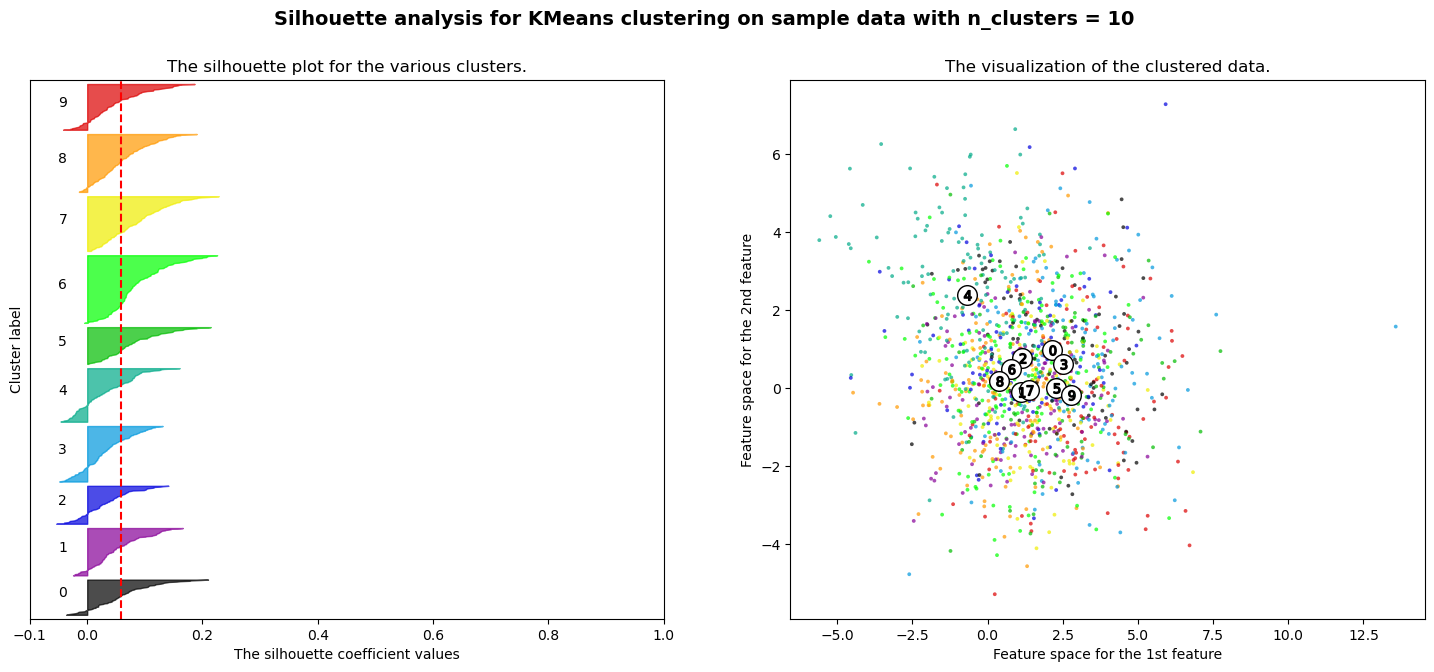

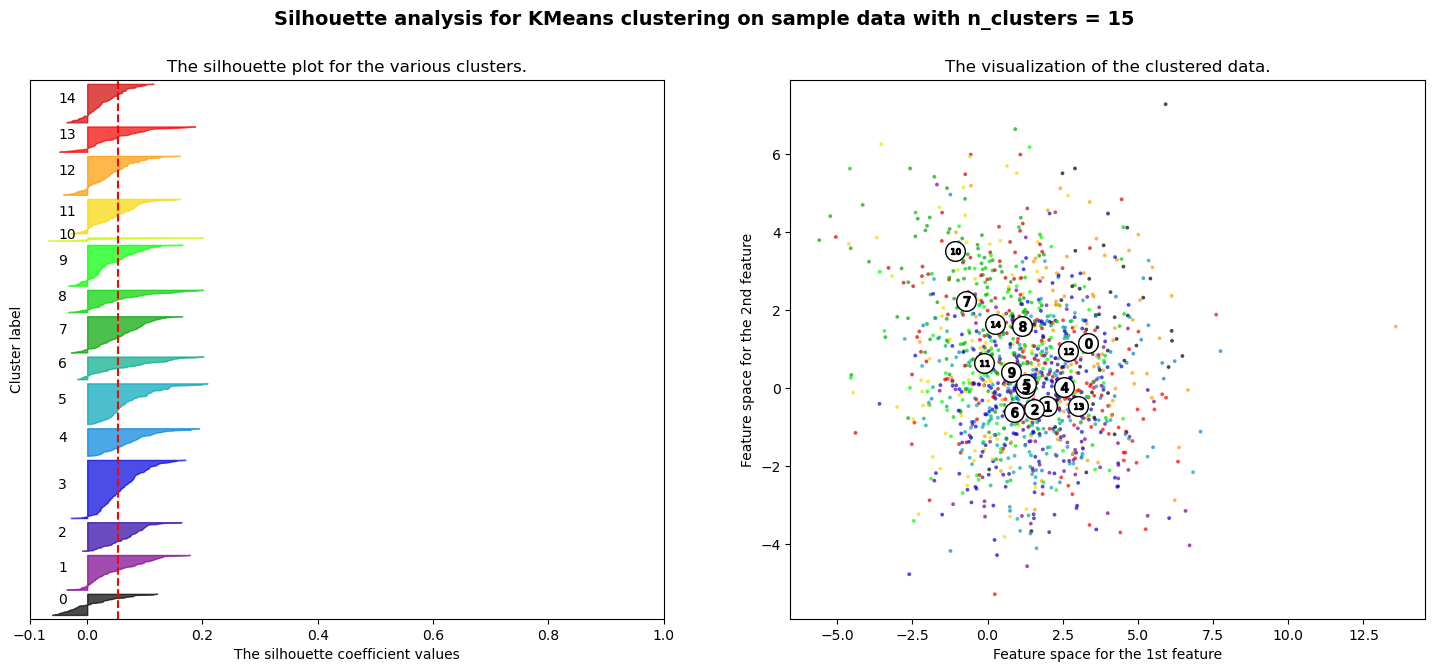

In [24]:
# Embedding 

data = df_news

# Removing special character
words = express_remove(data) 

# Removing english stop words 
words = stopwords_remove(words)

# Removing choosen words base on context
words = choosenwords_remove(words)

# Applying the embedding
emb = pd.DataFrame(words.apply(map_vectors, axis=1))
emb = pd.DataFrame(emb[0].to_list(), columns=list(range(0,50)))

X = np.array(emb)

range_n_clusters = [2,3,4,5,7,10,15]

silhouettes(X, range_n_clusters)

In [25]:
cluster_titles(X,4,df_news)

Cluster 1:
- Change lions' names as Hindu sentiments hurt: court
- Anger and fear in India state over elephant attacks
- Rwanda plan will fix asylum loophole - minister
- India farmers to resume march to Delhi after crackdown
- Nicolas Sarkozy gets six months for illegal campaign funding

Cluster 2:
- Court of Appeal to rule on Shamima Begum citizenship
- Woman feels 'fortunate' to survive five cancer diagnoses
- Cheshire paedophile who ran global child abuse site jailed
- Michael Longley: Film delves into work of award-wining poet
- Parenting YouTuber Ruby Franke jailed for child abuse

Cluster 3:
- How Russia has rebranded Wagner in Africa
- Robot inventor: 'We had to adapt to the AI revolution'
- Russia arrests German for carrying cannabis gummy bears
- Farmers can't do what they like with subsidies - FM
- One million have undiagnosed diabetes in England

Cluster 4:
- Gaza City: Drone video shows extensive destruction in seaside city
- Fifteen dead and dozens injured in China flat f

## News data conclusion

### Without the influence of the sports articles, there is better separation of topics between the clusters. We see news articles covering politics, world events, and crime.

### Similar to the Sports dataset, PCA improved the silhouette scores, but pre-trained embeddings still offered a slightly better result. Once again, the low average scores indicate that KMeans may not be the most suitable clustering technique for our data.

# Final Results and Conclusions:

### We believe the following should be considered as potentially influencing our results:

### - Since we are only using articles from BBC news, there may be more articles surrounding topics that affect the UK, which can introduce a regional bias.

### - Due to the free API limitation of 100 articles per request (and only as far back as 30 days), our range of events is limited. Furthermore, since the articles are sorted based on relevancy, there is a bias as to what is considered relevant. This may be the reason for the large supply of sports-related articles.

### - As a separate process, we attempted to retrieve articles from all news sources (instead of only BBC News) but still found the issue of having a large number of sports articles. Therefore, we question the API's method of sorting data that it deems 'relevant'. 

### We did not experiment with clustering techniques outside of KMeans, therefore it is possible we would have achieved better results with models such as Agglomerative Clustering, DBSCAN, Gaussian Mixture, etc.